# Initial Exploratory Data Analysis for the HR Separation (hrsepara) project
## Identify the correct working directory for source data
* '/data/discovery/hrsepara/core/'
## Identify the correct working directory for the analysis (both HDFS and LFS)
* '/data/discovery/hrsepara/staging/eda' and  '/home/kesj/working/hrsepara/eda/'
## begin to summarize data 


In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'


In [2]:
import os,subprocess
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# check if the path exists
os.path.exists(stgdir1local)

True

In [4]:
def hdfs_path_doesnt_exist(path):
    return subprocess.call(['hdfs','dfs','-ls',path])
    # returns 0 if doesnt_exist; 1 otherwise
    

In [5]:
# make the remote directory
if not hdfs_path_doesnt_exist(stgdir1):
    !hdfs dfs -mkdir {stgdir1}

mkdir: `/data/discovery/hrsepara/staging/eda': File exists


In [6]:
# check if the path exists
if not os.path.exists(stgdir1local):
    # make the local directory
    !mkdir {stgdir1local}
    #'/home/kesj/work/hrsepara/eda'


%pwd

u'/home/kesj/ipynb/HRsepara'

In [7]:
%cd {stgdir1local}

/home/kesj/work/hrsepara/eda


In [8]:
#define the currentworking directory:
cwd = os.path.abspath(os.curdir)
print cwd

/home/kesj/work/hrsepara/eda


## Look at the files in {coredir}

In [9]:
fnames = !hdfs dfs -ls {coredir}
infilenames = [f.split()[-1] for f in fnames[1:]]
print len(infilenames)

16


In [10]:
infilenames

['/data/discovery/hrsepara/core/EAS',
 '/data/discovery/hrsepara/core/EMPL',
 '/data/discovery/hrsepara/core/HISTCURR',
 '/data/discovery/hrsepara/core/HISTRET',
 '/data/discovery/hrsepara/core/HISTRETold',
 '/data/discovery/hrsepara/core/SBR',
 '/data/discovery/hrsepara/core/SR_BENEFIT.txt',
 '/data/discovery/hrsepara/core/SR_CKE.txt',
 '/data/discovery/hrsepara/core/SR_COMP.txt',
 '/data/discovery/hrsepara/core/SR_CPR.txt',
 '/data/discovery/hrsepara/core/SR_EAS.txt',
 '/data/discovery/hrsepara/core/SR_EDU.txt',
 '/data/discovery/hrsepara/core/SR_INS.txt',
 '/data/discovery/hrsepara/core/SR_LANG.txt',
 '/data/discovery/hrsepara/core/SR_LIC.txt',
 '/data/discovery/hrsepara/core/SR_RELO.txt']

# Now I need to get this data into a format so that I can read it from pandas

In [11]:
## function to load into pandas from hdfs (by copying to local filespace)
def pandas_read_hdfs(infile,sep = ';',dtype_dict = None):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    if dtype_dict != None:
        df = pd.read_csv(inname,sep=sep,dtype =dtype_dict)
    else:
        df = pd.read_csv(inname,sep=sep)
    # clean up local filespace
    !rm {inname}
    return df

## Load the base empl table

In [12]:
empl_df = pandas_read_hdfs(infilenames[1],dtype_dict={'KEY':np.str})
empl_df.shape

(334162, 20)

## Define types for specific columns

In [13]:
hist_record_dtype_dict = {'KEY':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SKEY':np.str,'JOBCODE':np.str,'EMPL_CLASS':np.str, 
                          'SHIFT':np.str,'COMPANY':np.str,'EXT_FUNC_ID_SFI':np.str,'FUNC_ID_SFI':np.str,
                          'DIVISION_CODE_SFI':np.str,'JOB_FAMILY':np.str,'JOB_FUNCTION':np.str,'ACTRES1':np.str,
                          'ACTRES2':np.str,'ACTRES3':np.str,'ACTRES4':np.str,'ACTRES5':np.str,'ACTRES6':np.str,
                          'ACTRES7':np.str,'ACTRES8':np.str,'ACTRES9':np.str,'ACTRES10':np.str,'BOX1':np.str,
                          'BOX2':np.str,'BOX3':np.str,'BOX4':np.str,'BOX5':np.str,'BOX6':np.str,'BOX7':np.str,
                          'BOX8':np.str,'BOX9':np.str,'BOX10':np.str,'RATE1':np.str,'RATE2':np.str,'RATE3':np.str,
                          'RATE4':np.str,'RATE5':np.str,'RATE6':np.str,'RATE7':np.str,'RATE8':np.str,'RATE9':np.str,
                          'RATE10':np.str}
#,'COUNT':np.float,'FUNC_CNT':np.float}
#dictionary to load the histcurr and histret columns the same way

## rename the last 2 columns of HISTCURR to match HISTRET

In [16]:
histcurr_df = pandas_read_hdfs(infilenames[2],dtype_dict=hist_record_dtype_dict)
print histcurr_df.shape#, histcurr_df.columns
# rename the last two columns to match histret
histcurr_df.rename(columns = {'COUNT':'FUNC_CNT','COUNT.1':'EXTFUNC_CNT'},inplace=True)

(70609, 159)


### load the updated HISTRET file from HDFS

In [15]:
histret_df = pandas_read_hdfs(infilenames[3],dtype_dict=hist_record_dtype_dict)
histret_df.shape#,histret_df.columns

(172554, 160)

In [16]:
#histret_df.columns[105:125]

In [17]:
histret_df['JOB_FUNCTION'].unique()

array([nan, 'NSA', 'PTB', 'PSA', 'MGT', 'PTA', 'PSB', 'PTC', 'PSC', 'PTI',
       'PTF', 'PTE', 'PTH', 'PTG', 'PTD', 'PTJ', 'PTM', 'PTL', 'H08', 'PTK'], dtype=object)

In [18]:
histret_df.VOLINVOL.value_counts()

VOLUNTARY      110899
INVOLUNTARY     60663
UNKNOWN           501
OTHER             491
dtype: int64

#### add a column to histcurr_df corresponding to the new  VOLINVOL column:
* value is 'NOT'

In [19]:
histcurr_df['VOLINVOL'] = 'NOT'

## Try to join EMPL, HISTCURR & HISTRET

In [20]:
ncurr = len(histcurr_df)
nret = len(histret_df)
print "number of current, retired, total, total_of_interest:",ncurr,nret,len(empl_df),ncurr + nret

number of current, retired, total, total_of_interest: 70609 172554 334162 243163


In [21]:
len(empl_df) - ncurr - nret # these are the canadian and Agency employees

90999

### some helper functions

In [22]:
# function to truncate POSTAL_ZIP to zip5
def truncate_postal_zip(in_zip):
    try:
        out_zip = in_zip[:5]
        #print out_zip
    except:
        #out_zip = str(in_zip)[:5]
        out_zip = np.nan
    return out_zip

In [23]:
def summarize_dataframe(df,show_example=False):
    nrow = len(df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        if show_example:
            print col, df[col].dtype,nmiss, "\t", len(df[col].unique()),":\t", df[col].ix[8320]
        else:
            print col, df[col].dtype,nmiss, "\t", len(df[col].unique())

In [24]:
def summarize_dataframe2(df,show_example=False):
    nrow = len(df)
    summary_df = pd.DataFrame(columns = ['Column','datatype','nmissing','arity','accepted values'])
    len_df = len(summary_df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        narity = len(df[col].unique())
        if show_example:
            print col, df[col].dtype,nmiss, "\t", narity,":\t", df[col].ix[8320]
        else:
            print col, df[col].dtype,nmiss, "\t", narity
        accept_val = None
        if narity < 20:
            accept_val = df[col].unique()
        summary_df.loc[len_df] = [col,df[col].dtype,nmiss,narity,accept_val]
        len_df+=1
    return summary_df

### merge the files 
* cur_empl
* ret_empl

In [25]:
ret_empl = pd.merge(histret_df,empl_df,left_on='KEY',right_on='KEY',how='inner')
cur_empl = pd.merge(histcurr_df,empl_df,left_on='KEY',right_on='KEY',how='inner')
print len(ret_empl),len(cur_empl)

172554 70609


## CLEAN UP THE DATA

### Remove the cases of ON(tario)

In [26]:
sum(cur_empl.LOC_STATE=='ON'), sum(ret_empl.LOC_STATE == 'ON')

(0, 7)

In [27]:
ret_empl = ret_empl[ret_empl.LOC_STATE != 'ON'] # drop them

## Check if there are missing termination dates from histret_df?


In [28]:
sum(ret_empl.TERMINATION_DT.isnull())
#histret_df[histret_df.TERMINATION_DT.isnull()]

73

### convert the date columns
* import datetime library
* identify the correct columns
* replace nan TERMINATION DATE with Jan, 1, 2015 for cur_empl
* calculate tenure
* calculate age at TERM DATE


In [29]:
# create list of date columns
date_columns = ['TERMINATION_DT','HIRE_DT','SERVICE_DT','LAST_HIRE_DT','BIRTHDATE']

In [30]:
##count how many of these are missing
print "Column\t     Current\t Retired"
print "++++++++++++++++++++++++++++++++++++"
for c in date_columns:
    print c, "\t",sum(cur_empl[c].isnull()), "\t",sum(ret_empl[c].isnull())

Column	     Current	 Retired
++++++++++++++++++++++++++++++++++++
TERMINATION_DT 	70609 	73
HIRE_DT 	0 	2
SERVICE_DT 	0 	0
LAST_HIRE_DT 	0 	1
BIRTHDATE 	0 	0


* replace the missing TERMINATION_DT with '01JAN2015'
* replace the missing HIRE_DT & LAST_HIRE_DT with SERVICE_DT for the Retired employees

In [31]:
termination_replace_dt = '01JAN2015'
ret_empl['TERMINATION_DT'].fillna(termination_replace_dt,inplace=True)
cur_empl['TERMINATION_DT'].fillna(termination_replace_dt,inplace=True)
#sum(ret_empl['TERMINATION_DT'].isnull())

In [32]:
#ret_empl[ret_empl['HIRE_DT'].isnull()].HIRE_DT = 
#ret_empl[
missing_idx =ret_empl[ret_empl['HIRE_DT'].isnull()].index
ret_empl.loc[missing_idx,'HIRE_DT'] = ret_empl.loc[missing_idx,'SERVICE_DT']
missing_idx =ret_empl[ret_empl['LAST_HIRE_DT'].isnull()].index
ret_empl.loc[missing_idx,'LAST_HIRE_DT'] = ret_empl.loc[missing_idx,'SERVICE_DT']

In [33]:
#now convert to datetimes
for c in date_columns:
    ret_empl[c]=ret_empl[c].apply(lambda x:datetime.strptime(x,'%d%b%Y')) 
    cur_empl[c]=cur_empl[c].apply(lambda x:datetime.strptime(x,'%d%b%Y')) 
#ret_empl[date_columns].apply(lambda x: datetime.strptime(x,'%d%b%Y'),axis=0)

In [34]:
## now calculate age at termination date
cur_empl['Age_tdelta'] = cur_empl['TERMINATION_DT']-cur_empl['BIRTHDATE']#)/np.timedelta64(1,'D')
ret_empl['Age_tdelta'] = ret_empl['TERMINATION_DT']-ret_empl['BIRTHDATE']#)/np.timedelta64(1,'D')## calculate tenure at termination date (use service_date)
# Use HIRE_DATE (SERVICE DATE Can be later than termination date if they have been rehired)
cur_empl['Tenure_tdelta'] = cur_empl['TERMINATION_DT']-cur_empl['HIRE_DT']
ret_empl['Tenure_tdelta'] = ret_empl['TERMINATION_DT']-ret_empl['HIRE_DT']
# convert to days, months or years
cur_empl['Age_years'] = cur_empl['Age_tdelta']/np.timedelta64(1,'Y')
ret_empl['Age_years'] = ret_empl['Age_tdelta']/np.timedelta64(1,'Y')
# convert to months of tenure
cur_empl['Tenure_months'] = cur_empl['Tenure_tdelta']/np.timedelta64(1,'M')
ret_empl['Tenure_months'] = ret_empl['Tenure_tdelta']/np.timedelta64(1,'M')
#cur_empl['Tenure_months'] = cur_empl['Tenure_tdelta']/np.timedelta64(1,'D')



In [35]:
ret_empl.Age_years.describe(), cur_empl.Age_years.describe()

(count    172547.000000
 mean         37.290639
 std          13.720188
 min          14.609472
 25%          26.103205
 50%          33.687208
 75%          46.853803
 max          98.197773
 dtype: float64, count    70609.000000
 mean        43.646929
 std         11.307643
 min         16.424704
 25%         34.193721
 50%         44.830489
 75%         52.652690
 max         84.311108
 dtype: float64)

In [36]:
ret_empl.Tenure_months.describe(), cur_empl.Tenure_months.describe()

(count    172547.000000
 mean         90.312257
 std         126.589908
 min          -0.032855
 25%           6.340993
 50%          29.799380
 75%         120.511715
 max         781.519128
 dtype: float64, count    70609.000000
 mean       176.848788
 std        135.307106
 min          0.098565
 25%         35.516130
 50%        176.562147
 75%        285.278959
 max        738.972053
 dtype: float64)

## Prepare for survival analysis:
### Add column (status) to indicate if current (0) or former (1) employee

In [37]:
ret_empl['status'] = 1
cur_empl['status'] = 0
# now join
print len(ret_empl),len(cur_empl)
empltbl = pd.concat([ret_empl,cur_empl],axis=0)
print len(empltbl)

172547 70609
243156


## Remove 'current' Interns
* identified as those where GRADE == 'UNS'

In [38]:
pd.crosstab(cur_empl.INTERN, cur_empl.GRADE)

GRADE,AG3,AL6,AM4,AT1,AT2,AT3,AT4,AT5,AT6,AT7,...,RH4,RJ2,RJ3,RJ4,RL1,RL2,RL3,RL4,UES,UNS
INTERN,,,,,,,,,,,,,,,,,,,,,
N,82,22,7,1,1,3,1,9,1,2,...,0,6,1,2,19,95,32,6,313,0
Y,11,35,2,0,0,0,0,0,0,0,...,1,0,0,0,5,21,0,0,64,803


In [39]:
pd.crosstab(ret_empl.INTERN, ret_empl.GRADE)

GRADE,22,23,24,25,26,27,28,29,AG3,AL6,...,SF7,T1,T2,T3,T4,T5,UES,UNS,UNT,ZFL
INTERN,,,,,,,,,,,,,,,,,,,,,
N,55,22,13,11,14,20,21,10,128,0,...,204,88,59,32,8,2,578,0,2530,1
Y,2,1,0,1,0,0,0,0,3,3,...,4,0,0,0,0,0,166,42859,60,0


* 803 in cur_empl
* 42859 in ret_empl

In [42]:
empltbl2 = empltbl[empltbl.GRADE != 'UNS'].copy()
len(empltbl2)

199494

In [40]:
## define interns
interns = empltbl[empltbl.GRADE == 'UNS'].copy()
print len(interns)
interns.Age_years.describe(), interns.Tenure_months.describe()

43662


(count    43662.000000
 mean        34.244621
 std         12.330957
 min         14.609472
 25%         23.729440
 50%         31.784362
 75%         42.136389
 max         86.309780
 dtype: float64, count    43662.000000
 mean        18.179886
 std         42.103550
 min         -0.032855
 25%          2.135567
 50%          4.895378
 75%         11.630629
 max        616.423335
 dtype: float64)

In [43]:
empltbl2.Tenure_months.describe()

count    199494.000000
mean        136.728197
std         138.958993
min          -0.032855
25%          19.910060
50%          83.122857
75%         223.906035
max         781.519128
dtype: float64

## Deal with negative tenure months

In [44]:
sum(ret_empl.Tenure_months < 0), sum(ret_empl.TOT_MO_SERVICE_SFI < 0)

(146, 289)

In [41]:
sum(ret_empl.TOT_MO_SERVICE_SFI < 1), sum(ret_empl.Tenure_months < 1)

(7233, 7140)

In [45]:
print "tenure is negative: ", sum(empltbl2.TOT_MO_SERVICE_SFI < 0), sum(empltbl2.Tenure_months < 0)
print "tenure is less than 1 month: ", sum(empltbl2.TOT_MO_SERVICE_SFI < 1), sum(empltbl2.Tenure_months < 1)

tenure is negative:  148 75
tenure is less than 1 month:  2740 3119


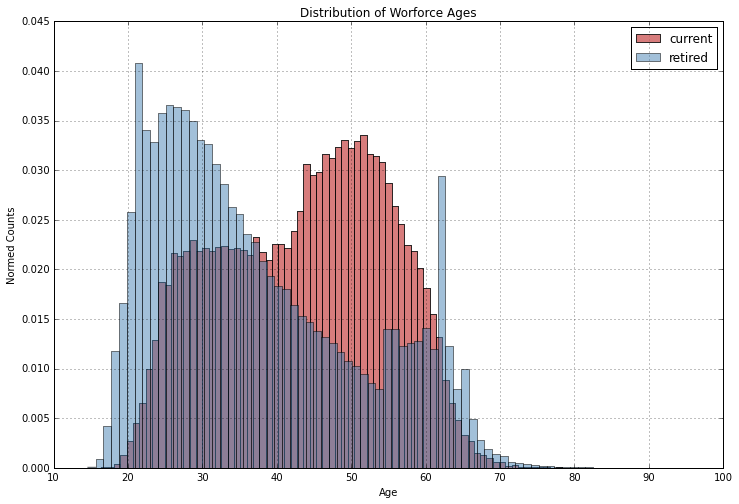

In [48]:
# look at these distributions
plt.figure(figsize=(12,8))
cur_empl.Age_years.hist(bins=80,color='indianred',label='current',alpha=0.8,normed=True)
ret_empl.Age_years.hist(bins=80,color='steelblue',label='retired',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Ages')

In [49]:
neg_tenure_idx = ret_empl[ret_empl.TOT_MO_SERVICE_SFI < 0].index
ret_empl.ix[neg_tenure_idx][['TOT_MO_SERVICE_SFI','Tenure_months','TERMINATION_DT','HIRE_DT','LAST_HIRE_DT','BIRTHDATE']].head(30)

,TOT_MO_SERVICE_SFI,Tenure_months,TERMINATION_DT,HIRE_DT,LAST_HIRE_DT,BIRTHDATE
1398,-219,20.140044,1988-05-27,1986-09-22,2008-04-07,1964-01-31
2754,-3,2.628391,1988-08-19,1988-05-31,1988-05-31,1956-04-22
3272,-13,147.321300,1988-09-16,1976-06-07,1976-06-07,1958-08-16
20341,-251,3.351198,1993-01-15,1992-10-05,1992-10-05,1974-05-24
20360,-244,7.852317,1993-01-20,1992-05-26,1992-05-26,1960-11-19
22606,-237,2.661246,1993-08-13,1993-05-24,1993-05-24,1959-02-26
26372,-219,26.053923,1994-07-29,1992-05-27,1994-05-19,1972-06-26
27114,-2,27.039570,1994-08-19,1992-05-18,1994-05-16,1973-02-22
32293,-166,6.899526,1995-08-25,1995-01-27,1995-01-27,1963-01-24
34018,-44,278.970821,1995-12-01,1972-09-01,1972-09-01,1955-05-11


In [50]:
neg_tenure_idx = ret_empl[ret_empl.Tenure_months < 0].index
ret_empl.ix[neg_tenure_idx][['TOT_MO_SERVICE_SFI','Tenure_months','TERMINATION_DT','HIRE_DT','LAST_HIRE_DT']].tail(30)

,TOT_MO_SERVICE_SFI,Tenure_months,TERMINATION_DT,HIRE_DT,LAST_HIRE_DT
144766,-1,-0.032855,2000-04-16,2000-04-17,2000-04-17
144920,-1,-0.032855,2006-05-05,2006-05-06,2006-05-06
145468,-1,-0.032855,2008-05-13,2008-05-14,2008-05-14
145573,-1,-0.032855,2006-02-26,2006-02-27,2006-02-27
145801,-1,-0.032855,2001-09-03,2001-09-04,2001-09-04
146571,-1,-0.032855,2001-05-11,2001-05-12,2001-05-12
146572,-1,-0.032855,2001-05-11,2001-05-12,2001-05-12
146658,-1,-0.032855,2000-03-12,2000-03-13,2000-03-13
146659,-1,-0.032855,2000-03-12,2000-03-13,2000-03-13
147955,-1,-0.032855,2008-02-03,2008-02-04,2008-02-04


In [51]:
ret_empl.ix[neg_tenure_idx]['KEY'].tail().values

array(['233293510150767', '281156981494816', '849342842050522',
       '851255668723609', '874169302580026'], dtype=object)

# Cleaning up these dates
### remove the negative tenure cases

In [52]:
empltbl3 = empltbl2[empltbl2.Tenure_months>=0].copy()
len(empltbl3)

199419

In [53]:
# how many are younger than 16?
sum(empltbl3.Age_years < 16.01), sum(empltbl3.Age_years > 70)#, sum(cur_empl.Age_years < 16.01)

(7, 537)

In [ ]:
#
time_checking_cols = [a for a in date_columns]
time_checking_cols.append('Tenure_months')
time_checking_cols.append('Age_years')
time_checking_cols.append('CUR_LOC_MOS')

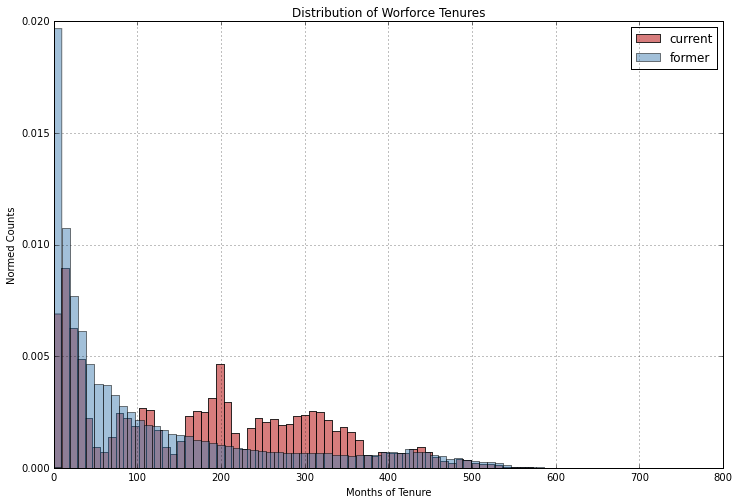

In [54]:
# look at these distributions
plt.figure(figsize=(12,8))
empltbl3[empltbl3.status==0].Tenure_months.hist(bins=80,color='indianred',label='current',alpha=0.8,normed=True)
empltbl3[empltbl3.status==1].Tenure_months.hist(bins=80,color='steelblue',label='former',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Months of Tenure')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Tenures')

In [55]:
## convert months of tenure to years of tenure
empltbl3['Tenure_years'] = empltbl3['Tenure_months']/12.0

In [56]:
empltbl3.Tenure_years.describe()

count    199419.000000
mean         11.398303
std          11.579984
min           0.000000
25%           1.659172
50%           6.929643
75%          18.669788
max          65.126594
dtype: float64

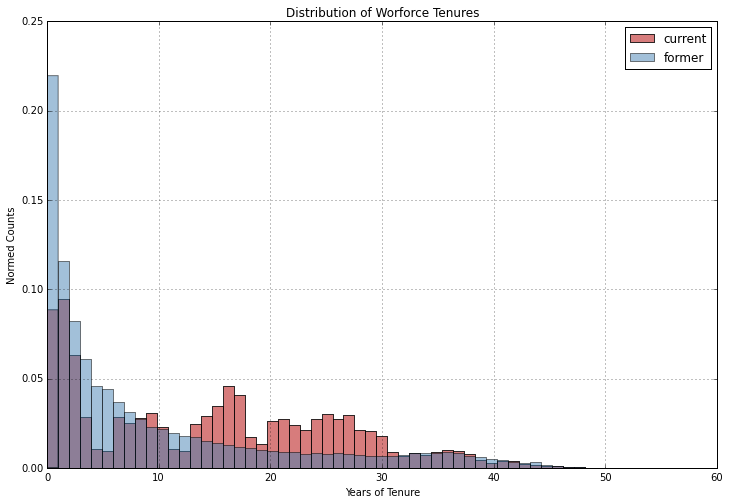

In [57]:
# look at these distributions
plt.figure(figsize=(12,8))
empltbl3[empltbl3.status==0].Tenure_years.hist(bins=60,range=[0,59],color='indianred',label='current',alpha=0.8,normed=True)
empltbl3[empltbl3.status==1].Tenure_years.hist(bins=60,range=[0,59],color='steelblue',label='former',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Years of Tenure')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Tenures')

## look for duplicated KEYS (and remove)

In [58]:
duplicated_keys_list = list(empltbl3.KEY.value_counts()[empltbl3.KEY.value_counts() >1].index)
duplicated_keys_list

[]

In [59]:
empltbl3.status.value_counts()

1    129613
0     69806
dtype: int64

## plot age distributions

In [60]:
empltbl3.Age_years.describe()

count    199419.000000
mean         40.210713
std          13.362226
min          15.263832
25%          28.594701
50%          38.207492
75%          51.445273
max          98.197773
dtype: float64

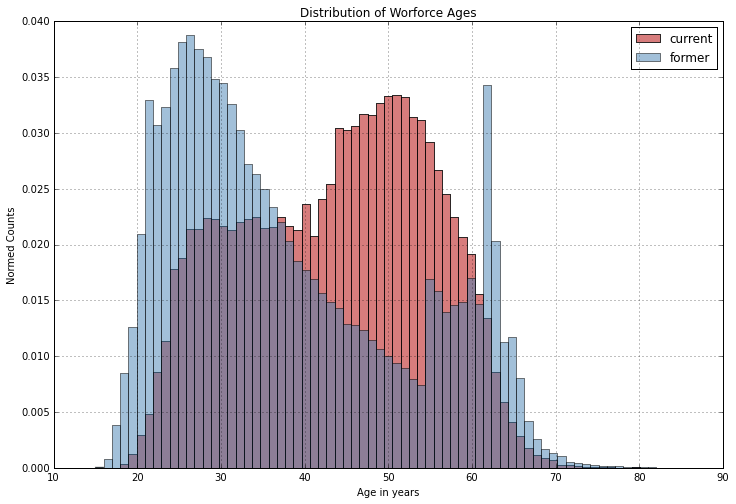

In [61]:
# look at these distributions
plt.figure(figsize=(12,8))
empltbl3[empltbl3.status==0].Age_years.hist(bins=70,range=[15,84],color='indianred',label='current',alpha=0.8,normed=True)
empltbl3[empltbl3.status==1].Age_years.hist(bins=70,range=[15,84],color='steelblue',label='former',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Age in years')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Ages')

### compare the type of separation

In [62]:
empltbl3.VOLINVOL.value_counts()

VOLUNTARY      90055
NOT            69806
INVOLUNTARY    38738
UNKNOWN          497
OTHER            323
dtype: int64

In [63]:
empltbl3.KEY.nunique()

199419

In [64]:
## Drop the TOT_MO_SERVICE_SFI column --> it's values seem to be erroneous generally
empltbl3.drop('TOT_MO_SERVICE_SFI',axis=1,inplace=True)

### Import and join BENEFITS information

In [846]:
bene_df = pandas_read_hdfs(infilenames[5],dtype_dict={'KEY':np.str})
bene_df.shape

(86954, 4)

In [849]:
bene_df.replace({'Y': 1, 'N':0},inplace=True)
bene_df.head()

,KEY,HAVE_INS,HAVE_DEP,COUNT
0,782034519027003,1,0,0
1,606846618748664,1,1,1
2,932378015449447,1,1,2
3,892115452742258,1,0,0
4,149888337659598,1,1,1


In [850]:
[sum(bene_df[c].isnull()) for c in bene_df.columns]

[0, 0, 0, 0]

In [851]:
empl_bene = pd.merge(empltbl3,bene_df,on='KEY',how = 'left')

In [860]:
len(empl_bene),empl_bene.VOLINVOL.value_counts()

(199419, VOLUNTARY      90055
 NOT            69806
 INVOLUNTARY    38738
 UNKNOWN          497
 OTHER            323
 dtype: int64)

### assign random numbers to the indices

In [65]:
## reindex the empltbl index
import random as random

In [66]:
list_of_indices = list(range(empltbl3.KEY.nunique()))
print len(list_of_indices )

199419


In [67]:
random.seed(883321)
#new_indices = [x for x in random.shuffle(list_of_indices)
random.shuffle(list_of_indices)#, len(list_of_indices))

In [68]:
empltbl3.index = list_of_indices # note that random.shuffle does this shuffling inplace
empltbl3.sort_index(inplace=True)
empltbl3.head()

,ACTRES1,ACTRES10,ACTRES2,ACTRES3,ACTRES4,ACTRES5,ACTRES6,ACTRES7,ACTRES8,ACTRES9,...,SUPVCNT5,SUPV_DIFF_LOC,TELE_MOS,TERMINATION_DT,TOTAL_RPT_CNT,Tenure_months,Tenure_tdelta,VOLINVOL,status,Tenure_years
0,MERIT;WINDOW 2 - EARLY RET INCENTIVE,MERIT,MERIT;MISCELLANEOUS DATA CHANGE;JOB RECLASSIFI...,MERIT;LOCATION/FLOOR CHANGE;JOB RECLASSIFICATION,REVIEW DATE CHANGE;MERIT;RATING SCALE CONVERSION,TRANSFER W/O JOB NUMBER CHANGE;COMPANY WIDE CO...,COST OF LIVING ADJUSTMENT;MERIT,MERIT,MERIT,MERIT,...,0,N,0,2004-08-31,8,443.212386,13490 days,INVOLUNTARY,1,36.934366
1,MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,N,0,2015-01-01,17,6.768106,206 days,NOT,0,0.564009
2,DISSATISFACTION;COMPANY WIDE CONVERSION;REGION...,TRANSFER W/O JOB NUMBER CHANGE;MERIT;COLA INDI...,MERIT,MERIT,MERIT,MERIT,ORGANIZATIONAL CHANGES;MERIT,MERIT,MERIT,MERIT;PROMOTION,...,0,Y,0,1997-06-16,NaN,235.503809,7168 days,VOLUNTARY,1,19.625317
3,MERIT;WINDOW 4 - EARLY RET INCENTIVE,MERIT;RRTR W/JOB NUMBER CHANGE;COLA INDICATOR ...,MERIT;MISCELLANEOUS DATA CHANGE,MERIT;MISCELLANEOUS DATA CHANGE;MISCELLANEOUS ...,MERIT;MISCELLANEOUS DATA CHANGE;JOB RECLASSIFI...,MERIT;PROMOTION;RATING SCALE CONVERSION,COMPANY WIDE CONVERSION;REGIONAL CONVERSION;CO...,JOB CODE CHANGE;COST OF LIVING ADJUSTMENT;MERIT,MERIT,MERIT;PROMOTION,...,4,N,0,2005-02-28,9,353.617117,10763 days,INVOLUNTARY,1,29.468093
4,MISCELLANEOUS DATA CHANGE;SALARY ADJUSTMENT;TR...,NaN,MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...,MISCELLANEOUS DATA CHANGE;EMPLOYEE NEW HIRE,NaN,NaN,NaN,NaN,NaN,NaN,...,5,N,0,2015-01-01,14,24.706873,752 days,NOT,0,2.058906


## Save this dataframe as a tab separated file

In [69]:
outfile1 = 'employee_dataframe.tsv'
save_dataframe_file = True
if save_dataframe_file:
    empltbl3.to_csv(outfile1,sep='\t')

## convert datetime64[ns] format to a string ---> YYYY-MM-DD 
use date_columns

In [70]:
for c in date_columns:
    empltbl3[c]= empltbl3[c].apply(lambda x: str(x).split(' ')[0])

In [71]:
for col in empltbl3.columns:
    my_dtype = empltbl3[col].dtype
    if my_dtype != 'object' and my_dtype != 'float64' and my_dtype != 'int64':
        print col, "\t", empltbl3[col].dtype, "\t",empltbl3[col].ix[8] 

Age_tdelta 	timedelta64[ns] 	748656000000000000 nanoseconds
Tenure_tdelta 	timedelta64[ns] 	81302400000000000 nanoseconds


In [ ]:
### try converting the timedeltas to floats
empltbl3['Age_tdelta'].ix[3].astype('float')/(60*60*24*10**9)

In [88]:
nano2days = 60.*60.*24.*10**9
empltbl3['Age_days'] = empltbl3['Age_tdelta'].apply(lambda x: x.astype('float')/(nano2days))
empltbl3['Tenure_days'] = empltbl3['Tenure_tdelta'].apply(lambda x: x.astype('float')/(nano2days))

In [89]:
empltbl3.drop(['Age_tdelta','Tenure_tdelta'], axis=1,inplace=True)
empltbl3.shape

(199419, 185)

In [90]:
len(empltbl3.Age_days.unique()), len(empltbl3.Tenure_days.unique())

(19297, 15729)

In [ ]:
empltbl.Age_years.ix[:10].apply(lambda x: int(np.round(x,0)))

In [ ]:
# Keep just the year
empltbl_dates = empltbl[date_columns].copy() # save the dates.
for c in date_columns:
    #print c
    if c.endswith('DT'):
        c2 = c[:-2]+'YEAR'
    else:
        c2 = c[:-4]+'_YEAR'
    #print c2
    empltbl[c2]= empltbl[c].apply(lambda x: x[:4])

In [ ]:
empltbl.drop(date_columns,axis=1,inplace=True)

In [ ]:
empltbl['Age_year_int'] = empltbl['Age_years'].apply(lambda x: int(np.round(x,0)))
empltbl['Tenure_year_int'] = empltbl['Tenure_months'].apply(lambda x: int(np.round(x/12,0)))

In [ ]:
len(empltbl.Age_year_int.unique()), len(empltbl.Tenure_year_int.unique())

In [ ]:
empltbl.Tenure_year_int.value_counts().plot(kind='bar',color='darkslateblue')

In [ ]:
#now save this version for H2O
outfile2 = 'employee_dataframe2.ssv'
save_dataframe_file = True
if save_dataframe_file:
    empltbl.to_csv(outfile2,sep=';')

In [ ]:
empltbl.shape

In [ ]:
# duplicated employee keys:
#[empltbl.KEY.value_counts() > 1]
dup_empl_keys = []
empltblKEYcounts = empltbl.KEY.value_counts()
for a in empltblKEYcounts[empltblKEYcounts>1].index:
    print a
    dup_empl_keys.append(a)

for empkey in dup_empl_keys:
    print empltbl[empltbl.KEY == empkey]

## Continue to Refine the input data

In [72]:
# add column for zip5
empltbl3['zip5'] = empltbl3['POSTAL_SFI'].apply(lambda x: truncate_postal_zip(x))

In [73]:
sum(empltbl3.zip5.isnull())

156

In [93]:
empltbl3[empltbl3.zip5=='SW18 '].values

array([[ 'COMPANY WIDE CONVERSION;REGIONAL CONVERSION;TRANSFER W/ JOB NUMBER CHANGE;MERIT;PROMOTION WITH MERIT INCREASE;COST OF LIVING ADJUSTMENT;ANOTHER OPPORTUNITY',
        nan,
        'EMPLOYEE NEW HIRE;TRANSFER W/O JOB NUMBER CHANGE;COST OF LIVING ADJUSTMENT;MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE',
        nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0,
        '18 BRATHWAY ROAD', nan, 33011.58, 35.414827135396344,
        '1965-04-17', 'S', nan, nan, nan, nan, nan, nan, nan, nan, nan,
        '005', 'A', 5.93548387, 5.93548387, 15.064516099999999, 3.19354839,
        3.19354839, 5.93548387, 1, 2, 2, 2, 9.0, '1', '2', 1, 1, 1, 1, '1',
        'S', 1.0, 1542.0, '00063', 0, 0, 0, 0, 999, 'Z', 1.0, 0, 0, 0, 0,
        'N', 'N', 'N', 'N', 'F', 0, 0, 0, 0, 36256.0, '00014', 'MA1', 1, 1,
        1, 1, '1999-06-14', 'N', 'N', 2, 2, 2, 2, '0153', nan, nan,
        '722822206897113', '1999-06-14', '50715013710', '07137', 1, 1, 1,
        1, 1, 1, 1, 1, 'MATTHEWS', 'NC'

In [74]:
empltbl3[empltbl3['STATE'].isnull()][['POSTAL_SFI','zip5','LOC_STATE','ADDRESS1']]

,POSTAL_SFI,zip5,LOC_STATE,ADDRESS1
642,NaN,NaN,NaN,NaN
751,NaN,NaN,NaN,NaN
1200,NaN,NaN,IL,53 MIDWAY ROAD SOUTHGATE
2042,NaN,NaN,MD,NaN
3974,NaN,NaN,TX,NaN
4266,NaN,NaN,NaN,NaN
9060,NaN,NaN,NaN,NaN
9119,NaN,NaN,TX,NaN
9560,SW1V 2HN,SW1V,CA,14 DEVONSHIRE HOUSE
11419,157220,15722,NY,"BANGHWA 3 - DONG, DONGIL SUITE 2 CHA 201-703"


In [75]:
sdf = summarize_dataframe2(empltbl3)

ACTRES1 object 10 	25528
ACTRES10 object 120394 	12096
ACTRES2 object 30298 	22260
ACTRES3 object 56834 	19761
ACTRES4 object 74610 	18075
ACTRES5 object 85633 	14497
ACTRES6 object 93197 	11931
ACTRES7 object 100055 	12926
ACTRES8 object 107740 	11037
ACTRES9 object 113980 	11376
ADDRCNT1 float64 112 	6
ADDRCNT10 float64 112 	15
ADDRCNT3 float64 112 	10
ADDRCNT5 float64 112 	12
ADDRESS1 object 114 	190462
ADDRESS2 object 185764 	7864
ANNUAL_RT float64 0 	123705
Age_tdelta timedelta64[ns] 0 	19297
Age_years float64 0 	19297
BIRTHDATE object 0 	24349
BOX1 object 70036 	4
BOX10 object 127992 	4
BOX2 object 61874 	4
BOX3 object 78279 	4
BOX4 object 89230 	4
BOX5 object 96888 	4
BOX6 object 103326 	4
BOX7 object 110835 	4
BOX8 object 116670 	4
BOX9 object 122677 	4
COMPANY object 0 	7
COMP_FREQUENCY object 0 	2
CUR_DEPT_MOS float64 0 	5388
CUR_EFUNC_MOS float64 0 	7917
CUR_FUNC_MOS float64 0 	9046
CUR_GRADE_MOS float64 0 	4876
CUR_JOB_MOS float64 0 	6476
CUR_LOC_MOS float64 0 	7883
DEPTCNT

## Examine cleaning up the different feature (covariate) columns for anylysis on them.


### restrict the dataframe to do linear-regression on.
* first attempt is _ad hoc_ reduction of 185 columns
    * keep age_years, tenure_months, status, sex for sure
* look at cases where there is 'significant' correlation between columns:
    * for example JOBCNTx, LOCCNTx, DEPTCNTx, ...

In [76]:
# define the set of columns that have missing values smaller than some threshold 
sdf['x_missing'] = sdf['nmissing']/len(empltbl3)
len(sdf[sdf['x_missing'] > 0]), len(sdf)

(83, 185)

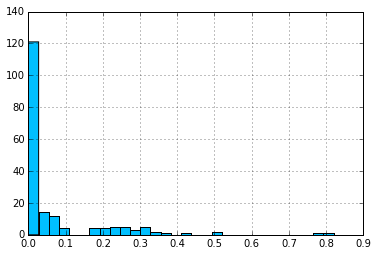

In [77]:
sdf['y_arity'] = sdf['arity']/len(empltbl)
sdf['y_arity'].hist(bins=30,color='deepskyblue')

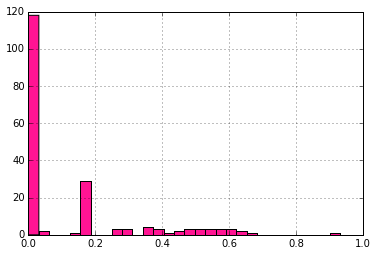

In [78]:
sdf['x_missing'].hist(bins=30,color='deeppink')

In [79]:
sdf.to_csv('employee_table_summary_3.csv')
# save to file

In [82]:
len(sdf)

185

In [162]:
# now apply some logic to these columns for keeping and not
columns_to_fix_missing = []
columns_to_fix_NY = []
columns_to_omit = []

### Procedure applies:
* Omit those that more than 25% missing.
* identify those that have between 0.1% and 25% missing
* add back in 2 columns of interest:
* Fix the missing values (imputation):
    - if categorical create new column
    - if float/int assign median
* convert Y/N to 1/0
* convert other columns



In [163]:
# omit those that have more than 25% missing:
missing_threshold = 0.25
columns_to_omit = list(sdf[sdf['x_missing'] > missing_threshold].Column.values)
print len(columns_to_omit)
#columns_to_omit

35


In [164]:
#missing_threshold = 0.25
print len(sdf[(sdf['x_missing']>0) & (sdf['x_missing'] <= missing_threshold)])
columns_to_fix_missing = list(sdf[(sdf['x_missing']>0) & (sdf['x_missing'] <= missing_threshold)].Column.values)
#print len(columns_to_fix_missing)

48


In [165]:
# add JOB_FAMILY and JOB_FUNCTION back into those to keep
job_columns_of_interest = ['JOB_FAMILY','JOB_FUNCTION']
for jcol in job_columns_of_interest:
    columns_to_omit.remove(jcol)
    columns_to_fix_missing.append(jcol)

len(columns_to_omit), len(columns_to_fix_missing)

(33, 50)

### look at the ones to fix missing that are objects

In [88]:
sdf[sdf.Column.isin(columns_to_fix_missing)]

,Column,datatype,nmissing,arity,accepted values,x_missing,y_arity
0,ACTRES1,object,10,25528,None,5.014567e-05,0.1049861
2,ACTRES2,object,30298,22260,None,0.1519314,0.09154617
10,ADDRCNT1,float64,112,6,"[0.0, 1.0, 3.0, nan, 2.0, 4.0]",0.0005616315,2.467552e-05
11,ADDRCNT10,float64,112,15,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan, 7.0, 6.0, ...",0.0005616315,6.168879e-05
12,ADDRCNT3,float64,112,10,"[0.0, 1.0, 2.0, 3.0, nan, 4.0, 6.0, 5.0, 7.0, ...",0.0005616315,4.112586e-05
13,ADDRCNT5,float64,112,12,"[0.0, 1.0, 2.0, 3.0, 4.0, nan, 5.0, 6.0, 7.0, ...",0.0005616315,4.935103e-05
14,ADDRESS1,object,114,190462,None,0.0005716607,0.7832914
43,DIVISION_CODE_SFI,object,15,10,"[1, 9, 0, 7, 2, 5, 3, 4, 6, nan]",7.521851e-05,4.112586e-05
52,EXTFUNC_CNT,float64,107,10352,None,0.0005365587,0.04257349
53,EXT_FUNC_ID_SFI,object,15,422,None,7.521851e-05,0.001735511


In [91]:
#sdf.ix[columns_to_fix_missing.index].datatype.value_counts()
sdf[sdf.Column.isin(columns_to_fix_missing)].datatype.value_counts()

float64    35
object     15
dtype: int64

## Logic to fix the missing (objects)

In [92]:
sdf[(sdf.Column.isin(columns_to_fix_missing)) & (sdf.datatype == 'object')]

,Column,datatype,nmissing,arity,accepted values,x_missing,y_arity
0,ACTRES1,object,10,25528,None,5.014567e-05,0.1049861
2,ACTRES2,object,30298,22260,None,0.1519314,0.09154617
14,ADDRESS1,object,114,190462,None,0.0005716607,0.7832914
43,DIVISION_CODE_SFI,object,15,10,"[1, 9, 0, 7, 2, 5, 3, 4, 6, nan]",7.521851e-05,4.112586e-05
53,EXT_FUNC_ID_SFI,object,15,422,None,7.521851e-05,0.001735511
75,FUNC_ID_SFI,object,15,64,None,7.521851e-05,0.0002632055
76,GRADE,object,526,164,None,0.002637662,0.0006744641
89,JOB_FAMILY,object,68868,1456,None,0.3453432,0.005987925
90,JOB_FUNCTION,object,68899,19,"[PTB, PSA, nan, NSA, PSC, PSB, PTD, MGT, PTA, ...",0.3454987,7.813914e-05
103,LOC_CITY,object,8837,3667,None,0.04431373,0.01508085


In [112]:
## try to compare state & loc_state to resolve
len(empltbl3[(empltbl3.STATE.isnull()) & (empltbl3.LOC_STATE.isnull())])

62

In [121]:
empltbl3.LOC_TYPE_DESCR_SFI.ix[:10]

0             OPERATIONS CENTER
1             OPERATIONS CENTER
2               REGIONAL OFFICE
3             OPERATIONS CENTER
4             OPERATIONS CENTER
5      AGENCY FIELD OFFICE(AFO)
6             OPERATIONS CENTER
7     CLAIM SERVICE CENTER(CSC)
8             OPERATIONS CENTER
9             OPERATIONS CENTER
10       CORPORATE HEADQUARTERS
Name: LOC_TYPE_DESCR_SFI, dtype: object

### only 62 have both LOC_STATE and STATE missing --> compare the values of each

In [123]:
len(empltbl3[(empltbl3.STATE!= empltbl3.LOC_STATE)][['STATE','LOC_STATE','zip5','LOC_CITY']])

25775

In [126]:
print len(empltbl3[(empltbl3.STATE.isnull()) & (empltbl3.LOC_STATE.notnull())][['STATE','LOC_STATE','zip5','LOC_CITY']])
empltbl3[(empltbl3.STATE.isnull()) & (empltbl3.LOC_STATE.notnull())][['STATE','LOC_STATE','zip5','LOC_CITY']]

92


,STATE,LOC_STATE,zip5,LOC_CITY
1200,NaN,IL,NaN,MENDOTA
2042,NaN,MD,NaN,CLINTON
3974,NaN,TX,NaN,EL PASO
9119,NaN,TX,NaN,RICHARDSON
9560,NaN,CA,SW1V,ROHNERT PARK
11419,NaN,NY,15722,LAKE SUCCESS
17939,NaN,TX,6065,HOUSTON
21510,NaN,FL,48012,BRADENTON
32564,NaN,CA,1784,CERRITOS
34730,NaN,IL,NaN,ELMHURST


* ACTRES1,ACTRES2,'ADDRESS1 --> to 'MISSING'
* EXT_FUNC_ID_SFI,FUNC_ID_SFI,zip5 --> XXXXX
* GRADE_JOB_FUNCTION --> XXX

In [127]:
chg_to_MISSING =['ACTRES1','ACTRES2','ADDRESS1','POSTAL_SFI','JOB_FAMILY', 'LOC_CITY','LOC_TYPE_DESCR_SFI']
chg_to_XXXXX = ['EXT_FUNC_ID_SFI','FUNC_ID_SFI','zip5']
chg_to_XXX = ['GRADE','JOB_FUNCTION']
chg_to_XX = ['STATE','LOC_STATE']

In [131]:
#'MISSING' in empltbl3.LOC_STATE.unique()
#empltbl3.LOC_STATE.ix[:10]
for acolumn in chg_to_MISSING:
    empltbl3.fillna({acolumn: 'MISSING'},inplace=True)

for acolumn in chg_to_XXXXX:
    empltbl3.fillna({acolumn: 'XXXXX'},inplace=True)

for acolumn in chg_to_XXX:
    empltbl3.fillna({acolumn: 'XXX'},inplace=True)

for acolumn in chg_to_XX:
    empltbl3.fillna({acolumn: 'XX'},inplace=True)


* DIVISION_CODE_SFI --> 15 missing replace with -1 and cast as int

In [97]:
empltbl3.fillna({'DIVISION_CODE_SFI': -1},inplace=True)
empltbl3['DIVISION_CODE_SFI'] = empltbl3['DIVISION_CODE_SFI'].apply(lambda x: int(x)) 
empltbl3.DIVISION_CODE_SFI.ix[:10]

0     1
1     9
2     1
3     9
4     9
5     9
6     9
7     0
8     0
9     9
10    9
Name: DIVISION_CODE_SFI, dtype: int64

In [132]:
### Now for non-objects that were missing:
sdf[(sdf.Column.isin(columns_to_fix_missing)) & (sdf.datatype == 'float64')]

,Column,datatype,nmissing,arity,accepted values,x_missing,y_arity
10,ADDRCNT1,float64,112,6,"[0.0, 1.0, 3.0, nan, 2.0, 4.0]",0.0005616315,2.467552e-05
11,ADDRCNT10,float64,112,15,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan, 7.0, 6.0, ...",0.0005616315,6.168879e-05
12,ADDRCNT3,float64,112,10,"[0.0, 1.0, 2.0, 3.0, nan, 4.0, 6.0, 5.0, 7.0, ...",0.0005616315,4.112586e-05
13,ADDRCNT5,float64,112,12,"[0.0, 1.0, 2.0, 3.0, 4.0, nan, 5.0, 6.0, 7.0, ...",0.0005616315,4.935103e-05
52,EXTFUNC_CNT,float64,107,10352,None,0.0005365587,0.04257349
74,FUNC_CNT,float64,27,12070,None,0.0001353933,0.04963891
109,MERIT1,float64,31535,78275,None,0.1581344,0.3219127
110,MERIT10,float64,31535,45401,None,0.1581344,0.1867155
111,MERIT2,float64,31535,81867,None,0.1581344,0.3366851
112,MERIT3,float64,31535,75515,None,0.1581344,0.3105619


###  logic
* change a few floats to ints:
    - ADDRCNT1,ADDRCNT10,ADDRCNT3,ADDRCNT5,EXTFUNC_CNT,FUNC_CNT
    - assign -1 to missing
* replace missing with median for others (PERF, MERIT, SAL)

In [133]:
missing_float_to_int = ['ADDRCNT1','ADDRCNT10','ADDRCNT3','ADDRCNT5','EXTFUNC_CNT','FUNC_CNT']
for acolumn in missing_float_to_int:
    empltbl3.fillna({acolumn: -1},inplace=True)
    empltbl3[acolumn] = empltbl3[acolumn].apply(lambda x: int(x)) 
    

In [137]:
missing_float_to_median = list(sdf[(sdf.Column.isin(columns_to_fix_missing)) & (sdf.datatype == 'float64')].Column[6:].values)

In [152]:
missing_median_values_series = empltbl3[missing_float_to_median].median()
missing_median_values_series.head()

MERIT1     856.215
MERIT10      0.000
MERIT2     936.780
MERIT3     737.000
MERIT4     484.330
dtype: float64

In [157]:
missing_median_values_series.loc['PERF4']

0.0

In [159]:
for acolumn in missing_float_to_median:
    med_value = missing_median_values_series.loc[acolumn]
    print acolumn, med_value
    empltbl3.fillna({acolumn:med_value},inplace=True)

MERIT1 856.215
MERIT10 0.0
MERIT2 936.78
MERIT3 737.0
MERIT4 484.33
MERIT5 124.32
MERIT6 0.0
MERIT7 0.0
MERIT8 0.0
MERIT9 0.0
PERF1 648.12
PERF10 0.0
PERF2 485.655
PERF3 0.0
PERF4 0.0
PERF5 0.0
PERF6 0.0
PERF7 0.0
PERF8 0.0
PERF9 0.0
SAL10 0.0
SAL2 38257.205
SAL3 34999.02
SAL4 31389.825
SAL5 27369.33
SAL6 18892.32
SAL7 0.0
SAL8 0.0
SAL9 0.0


### Again from an  __ad hoc__ perspective, reduce the number of columns.
The reasoning being that the data is historical or potentially redundant (e.g. Tenure_tdelta + Tenure_years)

In [166]:
# add the ACTRES2/3 and ADDRESS1/2 lines
# add *_tdelta, BIRTHDATE, PER_ORG
# add POSTAL_SFI, zip5, MAR_STA_SNAME_SFI, LOC_TYPE_DESC_SFI
others_to_omit = ['ADDRESS1','Age_tdelta','BIRTHDATE','LAST_HIRE_DT',
                  'LOC_CITY','LOC_TYPE_DESCR_SFI','MAR_STATUS_DT','MAR_STA_SNAME_SFI',
                  'PER_ORG','POSTAL_SFI','SKEY','SERVICE_DT','TERMINATION_DT',
                  'Tenure_tdelta','zip5']#'TOT_MO_SERVICE_SFI','Tenure_months']
                 #'MERIT1','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                 #'PERF1','PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']
history_to_omit = ['ADDRCNT10','ADDRCNT3','ADDRCNT5','DEPTCNT10','DEPTCNT3','DEPTCNT5',
                   'EFUNCCNT10','EFUNCCNT3','EFUNCCNT5','FLOORCNT10','FLOORCNT3','FLOORCNT5',
                  'FTPTCNT10','FTPTCNT3','FTPTCNT5','FULLPART10','FULLPART3','FULLPART5',
                  'FUNCCNT10','FUNCCNT3','FUNCCNT5','GRADECNT10','GRADECNT3','GRADECNT5',
                  'JOBCNT10','JOBCNT3','JOBCNT5','LOCCNT10','LOCCNT3','LOCCNT5','LOCSTCNT10','LOCSTCNT3','LOCSTCNT5',
                  'PARTFULL10','PARTFULL3','PARTFULL5','PTFTCNT10','PTFTCNT3','PTFTCNT5',
                   'SUPVCNT10','SUPVCNT3','SUPVCNT5','ACTRES2','SAL10','SAL9','SAL8','SAL7','SAL6','SAL5','SAL4','SAL3',
                   'SAL2','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                    'PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']
cols_to_categorical = ['COMPANY','COMP_FREQUENCY','DIVISION_CODE_SFI','EEO1CODE','EMPL_CLASS','EMPL_TYPE','ETHNIC_GROUP',
                       'FLSA_STATUS','FULLPART1','FULL_PART_TIME','GRADE','HUBIND','INTERN','JOB_FUNCTION','RELOCATE_ALL_SFI',
                       'REMOTE','REMOTE_SUPV','SEX','SHIFT','SUPV_DIFF_LOC','VOLINVOL','status']
for col in others_to_omit:
    columns_to_omit.append(col)

for col in history_to_omit:
    columns_to_omit.append(col)
    
print len(columns_to_omit),len(cols_to_categorical)

118 22


In [167]:
# define columns to keep
columns_to_keep = list(set(empltbl3.columns)-set(columns_to_omit))
len(columns_to_keep)

69

In [168]:
empltbl4 = empltbl3[columns_to_keep].copy()
print empltbl4.shape

(199419, 69)


In [169]:
sdf4 = summarize_dataframe2(empltbl4)

EXT_FUNC_ID_SFI object 0 	422
EMPL_CLASS object 0 	12
REH_CNT int64 0 	18
FLOR_SFI int64 0 	115
FULL_PART_TIME object 0 	4
ACTRES1 object 0 	25528
EEO1CODE object 0 	11
SHIFT object 0 	4
FUNCCNT1 int64 0 	4
LOC_STATE object 0 	52
INTERN object 0 	2
GRADE object 0 	164
TELE_MOS float64 0 	388
PERF1 float64 0 	78699
SUPVCNT1 int64 0 	12
ANNUAL_RT float64 0 	123705
LEGACY_DEPT_SFI object 0 	42660
CUR_LOC_MOS float64 0 	7883
Tenure_years float64 0 	15729
JOB_FAMILY object 0 	1456
ADDRCNT1 int64 0 	6
Age_years float64 0 	19297
COMPANY object 0 	7
CUR_JOB_MOS float64 0 	6476
FUNC_CNT int64 0 	12070
SEX object 0 	2
FULLPART1 object 0 	2
ETHNIC_GROUP float64 0 	8
RELOCATE_ALL_SFI object 0 	2
LOCATION object 0 	13535
HUBIND object 0 	2
Tenure_months float64 0 	15729
STD_HOURS float64 0 	144
JOBCNT1 int64 0 	7
FLOORCNT1 int64 0 	6
MIN_RT_ANNUAL float64 0 	1441
PTFTCNT1 int64 0 	3
KEY object 0 	199419
FLSA_STATUS object 0 	3
FTPTCNT1 int64 0 	3
CUR_GRADE_MOS float64 0 	4876
GRADECNT1 int64 0 	5
E

## convert binary columns to 0,1 in empl_bene and save

In [862]:
[sum(empl_bene[c].isnull()) for c in columns_to_fix_NY]

[0, 0, 0, 0, 0, 0, 0, 0]

In [866]:
for c in columns_to_fix_NY:
    if c == 'SEX':
        empl_bene.replace({c:{'M':0,'F':1}},inplace=True)
    else: 
        empl_bene.replace({c:{'N':0,'Y':1}},inplace=True)
        
empl_bene.INTERN.value_counts()

0    188005
1     11414
dtype: int64

In [867]:
pd.crosstab(empl_bene.FULLPART1,empl_bene.PARTFULL1)

PARTFULL1,0,1
FULLPART1,,
0,196520,1703
1,1106,90


In [868]:
empl_bene['COMP_FREQ_ANNUAL'] = 1
empl_bene.loc[empl_bene['COMP_FREQUENCY']=='H','COMP_FREQ_ANNUAL'] = 0
empl_bene.drop('COMP_FREQUENCY',axis=1,inplace=True)

In [869]:
#empl_ben
#encode the VOLINVOL column as ['INVOLUNTARY':2,'VOLUNTARY':1,'NOT':0,'
empl_bene['sep_status'] = empl_bene['VOLINVOL'].replace({'NOT':0,'VOLUNTARY':1,'INVOLUNTARY':2,'OTHER':3,'UNKNOWN':3})
empl_bene.sep_status.value_counts()
empl_bene.drop('VOLINVOL',axis=1,inplace=True)

In [ ]:
empl_bene.to_csv('employee_dataframe7long.tsv',sep='\t',index=False)

In [170]:
save_this_file = True
if save_this_file:
    empltbl4.to_csv('employee_dataframe4.tsv',sep='\t',ignore_index =True)

In [174]:
sdf4[sdf4.arity==2]

,Column,datatype,nmissing,arity,accepted values
10,INTERN,object,0,2,"[N, Y]"
25,SEX,object,0,2,"[M, F]"
26,FULLPART1,object,0,2,"[N, Y]"
28,RELOCATE_ALL_SFI,object,0,2,"[N, Y]"
30,HUBIND,object,0,2,"[N, Y]"
51,status,int64,0,2,"[1, 0]"
52,REMOTE,object,0,2,"[N, Y]"
53,REMOTE_SUPV,object,0,2,"[N, Y]"
55,SUPV_DIFF_LOC,object,0,2,"[N, Y]"
61,PARTFULL1,object,0,2,"[N, Y]"


In [494]:
empltbl4.shape

(199419, 70)

In [495]:
empltbl4.SHIFT.value_counts()

1    160986
N     36132
2      1682
3       619
dtype: int64

### Logic to transform the binary categorical columns
* column = SEX; 1 = Male, 0 = female
* column = COMP_FREQUENCY --> new column: comp_frequency_annual (1 = A, 0 = H (hourly))
* other columns Y == 1, N == 0

In [ ]:
empltbl4['COMP_FREQ_ANNUAL'] = 1
empltbl4.loc[empltbl4['COMP_FREQUENCY']=='H','COMP_FREQ_ANNUAL'] = 0
empltbl4.drop('COMP_FREQUENCY',axis=1,inplace=True)

# now deal with male,female
empltbl4.replace({'SEX':{'M': 1,'F':0}},inplace=True)
empltbl4[['COMP_FREQ_ANNUAL','SEX','SHIFT']].head()

In [181]:
# assign 1 to Y, 0 to N for the following columns
columns_to_fix_NY = ['INTERN','FULLPART1','RELOCATE_ALL_SFI','HUBIND','REMOTE','REMOTE_SUPV','SUPV_DIFF_LOC','PARTFULL1']
#empltbl4['COMP_FREQ_ANNUAL'] = empltbl4[
for acol in columns_to_fix_NY:
    empltbl4.replace({acol :{'Y':1,'N':0}},inplace=True) 

In [172]:
sdf4

,Column,datatype,nmissing,arity,accepted values
0,EXT_FUNC_ID_SFI,object,0,422,None
1,EMPL_CLASS,object,0,12,"[1, 3, D, T, O, 4, P, X, F, 5, 2, G]"
2,REH_CNT,int64,0,18,"[0, 2, 1, 5, 4, 3, 13, 10, 6, 7, 8, 11, 12, 15..."
3,FLOR_SFI,int64,0,115,None
4,FULL_PART_TIME,object,0,4,"[F, P, N, X]"
5,ACTRES1,object,0,25528,None
6,EEO1CODE,object,0,11,"[2, 5, 1, 3, 7, 4, N, 6, 8, L, 9]"
7,SHIFT,object,0,4,"[1, 3, N, 2]"
8,FUNCCNT1,int64,0,4,"[0, 1, 2, 3]"
9,LOC_STATE,object,0,52,None


In [183]:
sdf4[(sdf4.datatype=='object') &(sdf4.arity > 2)]

,Column,datatype,nmissing,arity,accepted values
0,EXT_FUNC_ID_SFI,object,0,422,None
1,EMPL_CLASS,object,0,12,"[1, 3, D, T, O, 4, P, X, F, 5, 2, G]"
4,FULL_PART_TIME,object,0,4,"[F, P, N, X]"
5,ACTRES1,object,0,25528,None
6,EEO1CODE,object,0,11,"[2, 5, 1, 3, 7, 4, N, 6, 8, L, 9]"
7,SHIFT,object,0,4,"[1, 3, N, 2]"
9,LOC_STATE,object,0,52,None
11,GRADE,object,0,164,None
16,LEGACY_DEPT_SFI,object,0,42660,None
19,JOB_FAMILY,object,0,1456,None


In [496]:
pd.crosstab(empltbl4.VOLINVOL,empltbl4.sep_status)

sep_status,0,1,2,3
VOLINVOL,,,,
INVOLUNTARY,0,0,38738,0
NOT,69806,0,0,0
OTHER,0,0,0,323
UNKNOWN,0,0,0,497
VOLUNTARY,0,90055,0,0


In [342]:
sum(empltbl4.sep_status <=1)

159861

In [344]:
vc_empl4 = empltbl4[empltbl4.sep_status<=1].copy()


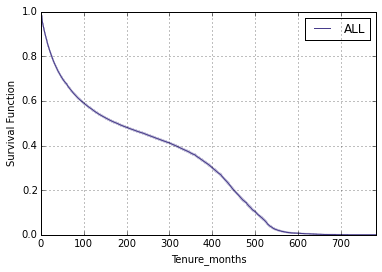

In [352]:
kmf_vc = KaplanMeierFitter()
kmf_vc.fit(vc_empl4.Tenure_months, vc_empl4.status,label='ALL')
kmf_vc.plot(color='darkslateblue')
plt.ylabel('Survival Function')
plt.xlabel('Tenure_months')

In [346]:
vc_empl4.JOB_FUNCTION.value_counts()

XXX    50004
PSA    42612
PTB    21787
PTA    14450
MGT     9849
PTE     4996
PTC     4688
NSA     4027
PSB     2575
PSC     2410
PTD      958
PTI      901
PTG      172
PTL      167
PTH      117
PTF      104
PTJ       21
PTK       21
PTM        2
dtype: int64

In [354]:
### Repeat for mgrs
print mg_codes
mgr = empltbl3.GRADE.isin(mg_codes)
sum(mgr)

['MG2', 'MG3', 'MG6', 'MG5', 'MG4', 'MG1', 'MG7']

In [362]:
#sum(vc_empl4[
print len(vc_empl4[vc_empl4.GRADE.isin(mg_codes)])
mgrA = vc_empl4.GRADE.isin(mg_codes)

9716


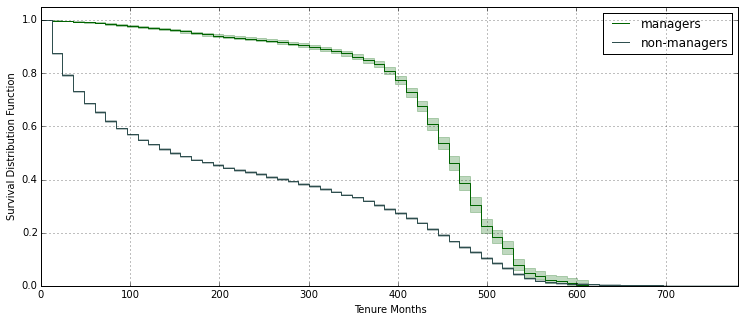

In [364]:
fig = plt.figure(figsize=(12.5,5))

kmf_mgr1=KaplanMeierFitter()

kmf_mgr1.fit(vc_empl4[mgrA].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[mgrA].status,label='managers')
mgrA_sf_df = pd.DataFrame(kmf_mgr1.survival_function_)
ax = fig.add_subplot(111)
kmf_mgr1.plot(ax=ax,c='darkgreen')
kmf_mgr1.fit(vc_empl4[~mgrA].Tenure_months, timeline=tenure_month_range,event_observed=vc_empl4[~mgrA].status,label='non-managers')
kmf_mgr1.plot(ax=ax,color='darkslategray')
mgrA_sf_df = pd.concat([mgrA_sf_df,kmf_mgr1.survival_function_],axis=1)
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

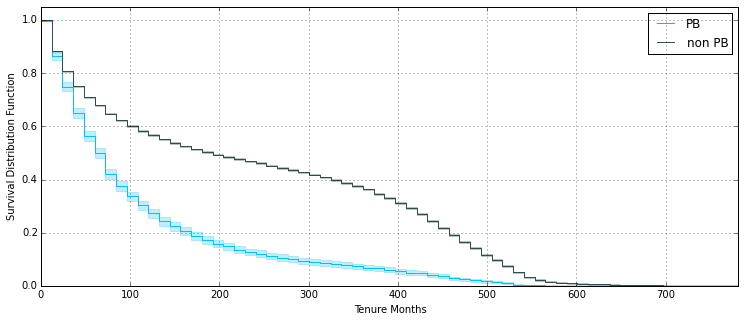

In [366]:
pb = vc_empl4.GRADE.isin(pb_codes)
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(vc_empl4[pb].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[pb].status,label='PB')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='deepskyblue')
kmf_grade.fit(vc_empl4[~pb].Tenure_months, timeline=tenure_month_range,event_observed=vc_empl4[~pb].status,label='non PB')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [386]:
kmf_grade.fit(vc_empl4[pb].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[pb].status,label='PB')
kmf_grade.survival_function_

,PB
timeline,
0.000000,0.997660
12.023371,0.864665
24.046742,0.748830
36.070114,0.649376
48.093485,0.563963
60.116856,0.500000
72.140227,0.420047
84.163598,0.374805
96.186970,0.336193


In [368]:
print pb_codes
sum(pb)

['PB1', 'PB3', 'PB2', 'PB4']


2564

In [370]:
mgrA_sf_df 

,managers,non-managers
timeline,,
0.000000,0.999897,0.999334
12.023371,0.998351,0.874779
24.046742,0.996175,0.793186
36.070114,0.994292,0.732276
48.093485,0.992074,0.686626
60.116856,0.989632,0.653725
72.140227,0.985570,0.619653
84.163598,0.981992,0.592121
96.186970,0.977665,0.569687


In [371]:
def lin_interpolate_df(df,index_to_find):
    #x1,x2 = locate_closest_indices(df,x)
    my_min = df.ix[:index_to_find].index[-1]
    my_max = df.ix[index_to_find:].index[0]
    deltax = my_max-my_min
    #print my_min, my_max
    y_1 = df.ix[my_min]
    y_2 = df.ix[my_max]
    #print y_1, y_2
    
    deltay=df.ix[my_max]- y_1
    slope = deltay/deltax
    #print slope, deltax, deltay
    my_value = y_1+slope*(index_to_find-my_min)
    return my_value

In [372]:
def calc_future_survival_proba(input_df,grp,sf_df,future_year_list):
    ## define a new data frame to hold the information
    current_tenure = input_df[grp][input_df.status==0].Tenure_months.copy()
    #current_mgr.columns='Current_tenure'#,inplace=True)
    new_df = pd.DataFrame()
    for future_year in future_years_list:
        cname = 'plus_'+str(future_year)+'yr'
        survival_prob = [lin_interpolate_df(sf_df,x) for x in current_tenure.values+future_year*12.0]
        a_df = pd.DataFrame(survival_prob,columns=[cname])
        new_df = pd.concat([new_df,a_df],axis=1)
    
    print new_df.shape
    return new_df

## this is alternatively able to be done by doing sum(kmf.predict(current.Tenure_months+t))/len(current)

In [377]:
mgrA_sf_df['managers']

timeline
0.000000      0.999897
12.023371     0.998351
24.046742     0.996175
36.070114     0.994292
48.093485     0.992074
60.116856     0.989632
72.140227     0.985570
84.163598     0.981992
96.186970     0.977665
108.210341    0.974492
120.233712    0.970532
132.257083    0.965780
144.280454    0.961444
156.303826    0.957190
168.327197    0.952356
...
613.191931    0
625.215302    0
637.238673    0
649.262045    0
661.285416    0
673.308787    0
685.332158    0
697.355529    0
709.378901    0
721.402272    0
733.425643    0
745.449014    0
757.472385    0
769.495757    0
781.519128    0
Name: managers, Length: 66, dtype: float64

In [ ]:
fig = plt.figure(figsize=(12.5,5))

kmf_mgr1=KaplanMeierFitter()

kmf_mgr1.fit(vc_empl4[mgrA].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[mgrA].status,label='managers')
mgrA_sf_df = pd.DataFrame(kmf_mgr1.survival_function_)
ax = fig.add_subplot(111)
kmf_mgr1.plot(ax=ax,c='darkgreen')
kmf_mgr1.fit(vc_empl4[~mgrA].Tenure_months, timeline=tenure_month_range,event_observed=vc_empl4[~mgrA].status,label='non-managers')
kmf_mgr1.plot(ax=ax,color='darkslategray')
mgrA_sf_df = pd.concat([mgrA_sf_df,kmf_mgr1.survival_function_],axis=1)
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [379]:
mgrA_surv_prob = calc_future_survival_proba(vc_empl4,mgrA,mgrA_sf_df['managers'],future_years_list)

(7931, 10)


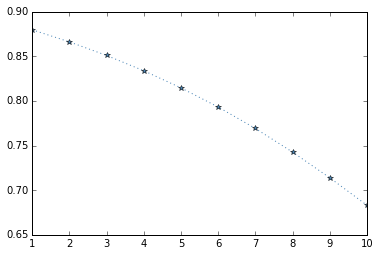

In [383]:
plt.plot(future_years_list,mgrA_surv_prob.sum()/len(mgrA_surv_prob),'*:',color='steelblue')

In [385]:
mgrA_surv_prob.sum()/len(mgrA_surv_prob)

plus_1yr     0.879615
plus_2yr     0.866092
plus_3yr     0.850882
plus_4yr     0.833735
plus_5yr     0.814546
plus_6yr     0.793095
plus_7yr     0.769097
plus_8yr     0.742607
plus_9yr     0.713822
plus_10yr    0.683030
dtype: float64

In [396]:
ues = vc_empl4.GRADE=='UES'
print sum(ues)

984


In [395]:
pd.crosstab(vc_empl4.GRADE,vc_empl4.status)

status,0,1
GRADE,,
22,0,31
23,0,17
24,0,11
25,0,7
26,0,8
27,0,13
28,0,12
29,0,7
AG3,93,92


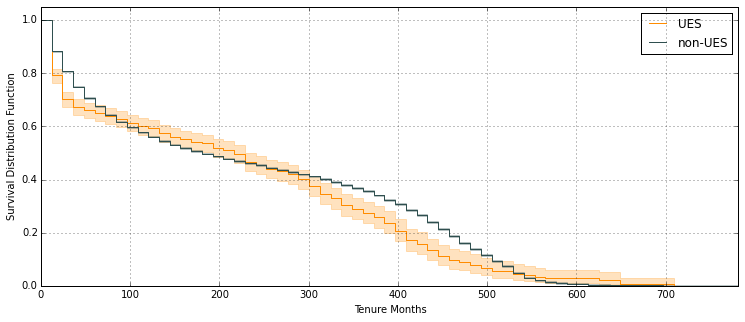

In [407]:
fig = plt.figure(figsize=(12.5,5))

kmf_ues=KaplanMeierFitter()

kmf_ues.fit(vc_empl4[ues].Tenure_months, timeline=tenure_month_range, event_observed=vc_empl4[ues].status,label='UES')
tmp_df = pd.DataFrame(kmf_ues.survival_function_)
ax = fig.add_subplot(111)
kmf_ues.plot(ax=ax,c='darkorange')
kmf_ues.fit(vc_empl4[~ues].Tenure_months, timeline=tenure_month_range,event_observed=vc_empl4[~ues].status,label='non-UES')
kmf_ues.plot(ax=ax,color='darkslategray')
tmp_df = pd.concat([tmp_df,kmf_ues.survival_function_],axis=1)
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [408]:
tmp_df.head()

,UES,non-UES
timeline,,
0.000000,1.000000,0.999364
12.023371,0.791495,0.882995
24.046742,0.701932,0.806663
36.070114,0.674023,0.749579
48.093485,0.660265,0.706778


In [401]:
vc_empl4[ues][vc_empl4['status']==0].head()

,EXT_FUNC_ID_SFI,EMPL_CLASS,REH_CNT,FLOR_SFI,FULL_PART_TIME,ACTRES1,EEO1CODE,SHIFT,FUNCCNT1,LOC_STATE,...,LOCCNT1,PARTFULL1,MERIT1,DEPTCNT1,FUNC_ID_SFI,EMPL_TYPE,CUR_FUNC_MOS,CUR_DEPT_MOS,COMP_FREQ_ANNUAL,sep_status
362,00927,1,1,999,F,MERIT;SALARY ADJUSTMENT,1,1,0,AZ,...,0,0,-17300.00,0,00009,S,109.838710,21.032258,1,0
513,00264,1,0,751,F,MISCELLANEOUS DATA CHANGE;TRANS/DEVELOPMENTAL/...,1,1,0,IL,...,0,0,4262.27,1,00038,S,259.225806,8.612903,1,0
1457,00315,1,0,999,F,LOCATION/FLOOR CHANGE;MISCELLANEOUS DATA CHANG...,1,1,0,IL,...,1,0,3113.63,1,00014,S,212.548387,7.677419,1,0
1521,00180,1,2,810,F,MISCELLANEOUS DATA CHANGE;MERIT,1,1,0,IL,...,0,0,0.00,0,00020,S,21.032258,21.032258,1,0
1820,00917,1,0,999,F,TRANS/DEVELOPMENTAL/NEW ASSIGN;INCENTIVE;MERIT,1,1,0,PA,...,0,0,1969.93,1,00014,S,201.032258,7.677419,1,0


In [416]:
len(tmp_df)

66

In [417]:
#kmf_grade.survival_function_
#tmp_df = pd.DataFrame(kmf_grade.survival_function_)
ues_surv_prob = calc_future_survival_proba(vc_empl4,ues,tmp_df['UES'],future_years_list)
ues_surv_prob.sum()/len(vc_empl4[ues][vc_empl4.status==0])

(377, 10)


plus_1yr     0.494751
plus_2yr     0.479475
plus_3yr     0.464038
plus_4yr     0.447484
plus_5yr     0.431299
plus_6yr     0.415637
plus_7yr     0.399868
plus_8yr     0.383505
plus_9yr     0.366198
plus_10yr    0.348305
dtype: float64

In [415]:
ues_surv_prob.sum()/sum(ues)

plus_1yr     0.189554
plus_2yr     0.183701
plus_3yr     0.177787
plus_4yr     0.171445
plus_5yr     0.165244
plus_6yr     0.159243
plus_7yr     0.153202
plus_8yr     0.146932
plus_9yr     0.140301
plus_10yr    0.133446
dtype: float64

In [419]:
empltbl4.columns

Index([u'EXT_FUNC_ID_SFI', u'EMPL_CLASS', u'REH_CNT', u'FLOR_SFI', u'FULL_PART_TIME', u'ACTRES1', u'EEO1CODE', u'SHIFT', u'FUNCCNT1', u'LOC_STATE', u'INTERN', u'GRADE', u'TELE_MOS', u'PERF1', u'SUPVCNT1', u'ANNUAL_RT', u'LEGACY_DEPT_SFI', u'CUR_LOC_MOS', u'Tenure_years', u'JOB_FAMILY', u'ADDRCNT1', u'Age_years', u'COMPANY', u'CUR_JOB_MOS', u'FUNC_CNT', u'SEX', u'FULLPART1', u'ETHNIC_GROUP', u'RELOCATE_ALL_SFI', u'LOCATION', u'HUBIND', u'Tenure_months', u'STD_HOURS', u'JOBCNT1', u'FLOORCNT1', u'MIN_RT_ANNUAL', u'PTFTCNT1', u'KEY', u'FLSA_STATUS', u'FTPTCNT1', u'CUR_GRADE_MOS', u'GRADECNT1', u'EFUNCCNT1', u'STATE', u'CUR_EFUNC_MOS', u'FTE', u'JOB_FUNCTION', u'SAL1', u'HIRE_DT', u'LOCSTCNT1', u'VOLINVOL', u'status', u'REMOTE', u'REMOTE_SUPV', u'JOBCODE', u'SUPV_DIFF_LOC', u'DIVISION_CODE_SFI', u'RELO_STATE_CNT_SFI', u'EXTFUNC_CNT', u'MAX_RT_ANNUAL', u'LOCCNT1', u'PARTFULL1', u'MERIT1', u'DEPTCNT1', u'FUNC_ID_SFI', u'EMPL_TYPE', u'CUR_FUNC_MOS', u'CUR_DEPT_MOS', u'COMP_FREQ_ANNUAL', u'sep_

In [418]:
vc_empl4.columns

Index([u'EXT_FUNC_ID_SFI', u'EMPL_CLASS', u'REH_CNT', u'FLOR_SFI', u'FULL_PART_TIME', u'ACTRES1', u'EEO1CODE', u'SHIFT', u'FUNCCNT1', u'LOC_STATE', u'INTERN', u'GRADE', u'TELE_MOS', u'PERF1', u'SUPVCNT1', u'ANNUAL_RT', u'LEGACY_DEPT_SFI', u'CUR_LOC_MOS', u'Tenure_years', u'JOB_FAMILY', u'ADDRCNT1', u'Age_years', u'COMPANY', u'CUR_JOB_MOS', u'FUNC_CNT', u'SEX', u'FULLPART1', u'ETHNIC_GROUP', u'RELOCATE_ALL_SFI', u'LOCATION', u'HUBIND', u'Tenure_months', u'STD_HOURS', u'JOBCNT1', u'FLOORCNT1', u'MIN_RT_ANNUAL', u'PTFTCNT1', u'KEY', u'FLSA_STATUS', u'FTPTCNT1', u'CUR_GRADE_MOS', u'GRADECNT1', u'EFUNCCNT1', u'STATE', u'CUR_EFUNC_MOS', u'FTE', u'JOB_FUNCTION', u'SAL1', u'HIRE_DT', u'LOCSTCNT1', u'VOLINVOL', u'status', u'REMOTE', u'REMOTE_SUPV', u'JOBCODE', u'SUPV_DIFF_LOC', u'DIVISION_CODE_SFI', u'RELO_STATE_CNT_SFI', u'EXTFUNC_CNT', u'MAX_RT_ANNUAL', u'LOCCNT1', u'PARTFULL1', u'MERIT1', u'DEPTCNT1', u'FUNC_ID_SFI', u'EMPL_TYPE', u'CUR_FUNC_MOS', u'CUR_DEPT_MOS', u'COMP_FREQ_ANNUAL', u'sep_

In [588]:
# encode the VOLINVOL column as ['INVOLUNTARY':2,'VOLUNTARY':1,'NOT':0,'
empltbl4['sep_status'] = empltbl4['VOLINVOL'].replace({'NOT':0,'VOLUNTARY':1,'INVOLUNTARY':2,'OTHER':3,'UNKNOWN':3})
empltbl4.sep_status.value_counts()

1    90055
0    69806
2    38738
3      820
dtype: int64

In [186]:
pd.crosstab(empltbl4.status,empltbl4.sep_status)

sep_status,0,1,2,3
status,,,,
0,69806,0,0,0
1,0,90055,38738,820


## Explore differences between voluntary/involuntary and Not 

In [97]:
volunt = empltbl3[empltbl3.VOLINVOL=='VOLUNTARY'].copy()
current = empltbl3[empltbl3.VOLINVOL=='NOT'].copy()
involu = empltbl3[empltbl3.VOLINVOL=='INVOLUNTARY'].copy()
empl_df_list = [current,volunt,involu]
print [len(a) for a in empl_df_list]

[69806, 90055, 38738]


In [136]:
len(empltbl3[(empltbl3.VOLINVOL=='VOLUNTARY') |(empltbl3.VOLINVOL=='NOT')])

159861

In [100]:
empl_df_list_colors =['indianred','steelblue','darkkhaki']
empl_df_list_alphas =[1.0,0.7,0.4]
empl_df_list_label = ['current','voluntary','involuntary']

In [102]:
## define histogram bin ranges
tenure_year_bin_range = [0,59]
age_year_bin_range = [15,84]

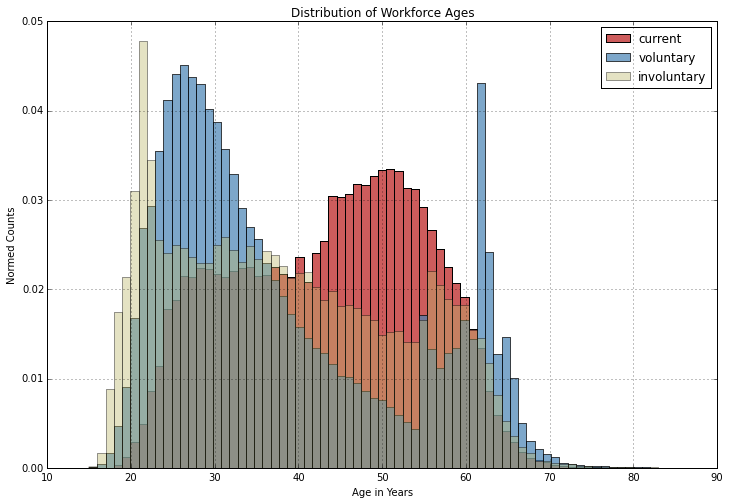

In [103]:
plt.figure(figsize=(12,8))
for idx in xrange(0,len(empl_df_list)):
    my_color = empl_df_list_colors[idx]
    my_alpha = empl_df_list_alphas[idx]
    empl_df_list[idx].Age_years.hist(bins=70,range=age_year_bin_range,color=my_color,alpha=my_alpha,normed=True,label=empl_df_list_label[idx])
    plt.legend()
    plt.xlabel('Age in Years')
    plt.ylabel('Normed Counts')
    plt.title('Distribution of Workforce Ages')

In [137]:
len(empltbl3[(empltbl3.VOLINVOL=='VOLUNTARY') & (empltbl3.Age_years > 54)])

19594

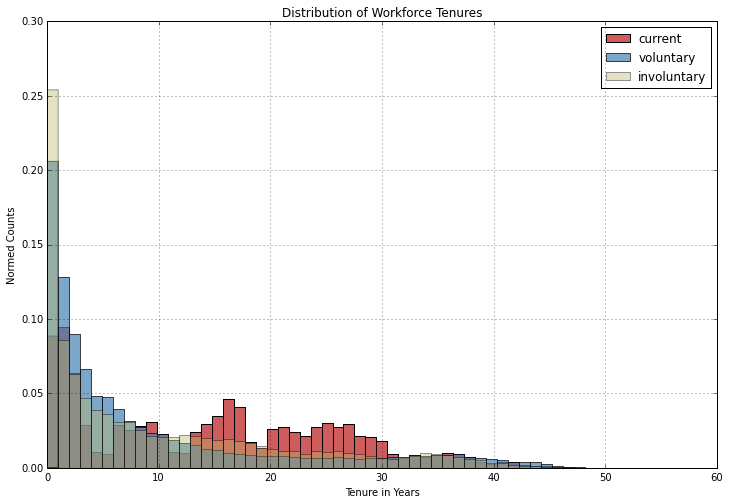

In [104]:
plt.figure(figsize=(12,8))
for idx in xrange(0,len(empl_df_list)):
    my_color = empl_df_list_colors[idx]
    my_alpha = empl_df_list_alphas[idx]
    empl_df_list[idx].Tenure_years.hist(bins=60,range=tenure_year_bin_range,color=my_color,alpha=my_alpha,normed=True,label=empl_df_list_label[idx])
    plt.legend()
    plt.xlabel('Tenure in Years')
    plt.ylabel('Normed Counts')
    plt.title('Distribution of Workforce Tenures')

In [ ]:
current.DIVISION_CODE_SFI.value_counts()

In [ ]:
current[(current.COMPANY=='005')].GRADE.value_counts()

In [ ]:
empltbl3[empltbl2.INTERN=='Y'].Tenure_months.hist(color='darkslategray',bins=80,normed=True)
empltbl3[empltbl2.INTERN=='N'].Tenure_months.hist(color='darkturquoise',bins=80,alpha=0.5, normed=True)

## Look at how many have missing SKEY
* only one in the current table.

In [105]:
#len(current[current.SKEY.isnull()][['Age_years','Tenure_months','COMPANY','GRADE','ANNUAL_RT','KEY']])
ceo_key = current[current.SKEY.isnull()].KEY.values[0]
print ceo_key
print current[current.SKEY.isnull()][['Age_years','Tenure_months','COMPANY','GRADE','ANNUAL_RT','KEY']]

230212589367392
       Age_years  Tenure_months COMPANY GRADE  ANNUAL_RT              KEY
72082  64.414738      472.02612     001    L1    1750000  230212589367392


In [106]:
len(empltbl3.KEY.unique()), len(empltbl3.SKEY.unique()),len(current.SKEY.unique())

(199419, 15042, 7985)

In [107]:
## How many are missing SKEY in retired.
sum(empltbl3[empltbl3.status==1].SKEY.isnull())

55411

# do survival analysis for each GRADE
* column == 'GRADE' 
* arity = 164
* Define a min-threshold of GRADE to look at.


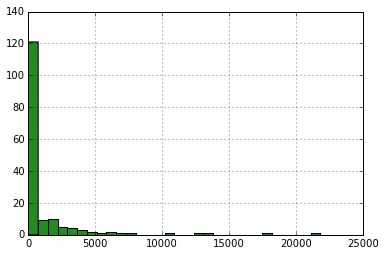

In [187]:
empltbl3.GRADE.value_counts().hist(color='forestgreen',bins=30)

In [188]:
## start with top 20 grades:
empltbl3.GRADE.value_counts()[:20]

PA2    21799
RB2    17648
PA1    13791
PA3    12882
SF4    10770
SF3     7386
MA3     6790
RA2     6165
RA3     6087
MG3     5615
RB1     4471
MA2     4443
C3      4353
MA1     3870
PA4     3804
SF5     3439
NON     3316
RC2     3292
SF2     3147
UNT     2585
dtype: int64

## Survival analysis

In [189]:
#use lifelines
from lifelines import KaplanMeierFitter
kmf0 = KaplanMeierFitter()

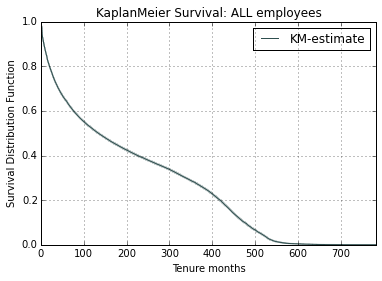

In [190]:

plt.figure(figsize=(14,6))

kmf0.fit(empltbl3.Tenure_months, event_observed=empltbl3.status)
kmf0.plot(color='darkslategray')
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure months')
plt.title('KaplanMeier Survival: ALL employees')

In [191]:
## define the range so all are on the same scale
min_tenure_months= empltbl3.Tenure_months.min()
max_tenure_months = empltbl3.Tenure_months.max()
print min_tenure_months, max_tenure_months
tenure_month_range = np.linspace(min_tenure_months,max_tenure_months,66)
len(tenure_month_range)

0.0 781.519127703


66

In [ ]:
empltbl3.GRADE.value_counts()[:40]

In [192]:
## replace nan with 'XXX'
empltbl3.GRADE.fillna('XXX',inplace=True)

In [193]:
mg_codes = [x for x in list(empltbl3.GRADE.unique()) if  str(x).startswith('MG')]

In [195]:
mg_codes = [x for x in list(empltbl3.GRADE.unique()) if  str(x).startswith('MG')]
clvl_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('C')]
ra_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RA')]
re_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RE')]
rd_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RD')]
pa_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('PA')]
pb_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('PB')]
ma_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('MA')]
sf_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('SF')]
rb_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RB')]
rc_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RC')]
pc_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('PC')]
l_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('L')]
fa_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('FA')]
u_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('U')]
i_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('I')]
a_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('A')]
b_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('B')]
#ri_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('RI')]
# assign missing and non to non_codes
non_codes = ['NON','XXX']
m_codes = ['M1N','M2N','M3N','M10']
rx_codes = ['RF1', 'RF2', 'RF3', 'RG1', 'RG2', 'RG3', 'RG4', 'RH1', 'RH2', 'RH3', 'RH4', 
            'RI2', 'RI3', 'RJ2', 'RJ3', 'RJ4', 'RK3','RL1', 'RL2', 'RL3', 'RL4', 'RM2']
# combine
two_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('2')]
t_codes = [x for x in list(empltbl3.GRADE.unique()) if str(x).startswith('T')]
oth_codes = i_codes+two_codes+t_codes+a_codes
oth_codes.append('ZFL')


In [196]:
grade_groupings_list_A = [mg_codes,clvl_codes,ma_codes,pa_codes,pb_codes,sf_codes, ra_codes,rd_codes,re_codes, rb_codes, rc_codes,
                          pc_codes,l_codes,fa_codes, u_codes,b_codes,non_codes,m_codes,rx_codes,oth_codes]
len(grade_groupings_list_A)


20

In [200]:
e3_grade_function_crosstab = pd.crosstab(empltbl3.GRADE,empltbl3.JOB_FUNCTION)
e3_grade_function_crosstab.MGT 

GRADE
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
AG3       0
AL6       0
AM4      12
AT1       0
AT2       0
AT3       0
AT4       0
...
SF2        0
SF3        0
SF4        0
SF5        0
SF6        0
SF7        0
T1         0
T2         0
T3         0
T4         0
T5         0
UES      129
UNT        0
XXX        0
ZFL        1
Name: MGT, Length: 164, dtype: int64

In [205]:
e3_grade_function_crosstab[e3_grade_function_crosstab.MGT>0] 

JOB_FUNCTION,MGT,NSA,PSA,PSB,PSC,PTA,PTB,PTC,PTD,PTE,PTF,PTG,PTH,PTI,PTJ,PTK,PTL,PTM,XXX
GRADE,,,,,,,,,,,,,,,,,,,
AM4,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MA4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1538
MA6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1427
MG1,193,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MG2,2198,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MG3,5615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MG4,2045,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
MG5,762,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
MG6,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [278]:
e3_grade_function_crosstab[e3_grade_function_crosstab.PTB>0] 

JOB_FUNCTION,MGT,NSA,PSA,PSB,PSC,PTA,PTB,PTC,PTD,PTE,PTF,PTG,PTH,PTI,PTJ,PTK,PTL,PTM,XXX
GRADE,,,,,,,,,,,,,,,,,,,
B01,0,0,0,0,0,0,171,0,0,0,0,0,0,0,0,0,0,0,0
B23,0,0,0,0,0,0,610,0,0,0,0,0,0,0,0,0,0,0,0
M2N,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1532
MA1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3869
MA2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,4441
RA1,1,0,2,0,0,1739,2,0,0,0,0,0,0,0,0,0,0,0,0
RA2,0,0,13,0,0,5422,521,0,0,0,0,0,0,209,0,0,0,0,0
RB1,0,0,0,0,0,0,4471,0,0,0,0,0,0,0,0,0,0,0,0
RB2,0,1,0,0,0,0,17647,0,0,0,0,0,0,0,0,0,0,0,0


In [201]:
for g in grade_groupings_list_A:
    print sum(empltbl3.GRADE.isin(g)), g

10974 ['MG2', 'MG3', 'MG6', 'MG5', 'MG4', 'MG1', 'MG7']
11909 ['C2', 'C3', 'C5', 'C4', 'C1', 'C6', 'C8', 'C9', 'C23', 'C7', 'C01']
19416 ['MA1', 'MA3', 'MA4', 'MA2', 'MA7', 'MA5', 'MA6', 'MA8', 'MA9']
52276 ['PA1', 'PA3', 'PA2', 'PA4']
4152 ['PB1', 'PB3', 'PB2', 'PB4']
28683 ['SF5', 'SF3', 'SF4', 'SF2', 'SF6', 'SF1', 'SF7']
16345 ['RA2', 'RA4', 'RA3', 'RA1']
940 ['RD2', 'RD3', 'RD4', 'RD1']
5411 ['RE4', 'RE3', 'RE2', 'RE1']
23415 ['RB2', 'RB1', 'RB3']
5128 ['RC1', 'RC2', 'RC3']
3116 ['PC3', 'PC2', 'PC4']
2568 ['LS1', 'LP1', 'LS2', 'L7', 'L10', 'LS3', 'L6', 'L4', 'L9', 'L8', 'L5', 'LM2', 'LM1', 'L2', 'L3', 'L1']
2179 ['FA5', 'FA3', 'FA1', 'FA4', 'FA2', 'FA6']
3705 ['UNT', 'UES']
888 ['B23', 'BC2', 'B01', 'BC3', 'BA1', 'BC4']
3842 ['NON', 'XXX']
2534 ['M1N', 'M2N', 'M3N', 'M10']
1172 ['RF1', 'RF2', 'RF3', 'RG1', 'RG2', 'RG3', 'RG4', 'RH1', 'RH2', 'RH3', 'RH4', 'RI2', 'RI3', 'RJ2', 'RJ3', 'RJ4', 'RK3', 'RL1', 'RL2', 'RL3', 'RL4', 'RM2']
766 ['IS2', 'IM1', 'IF3', 'IE3', 'IE2', 'IF1', 'IM2'

In [202]:
from itertools import chain
used_grades = list(chain.from_iterable(grade_groupings_list_A))
sum(empltbl3.GRADE.isin(used_grades)), len(empltbl3)

(199419, 199419)

In [203]:
sorted([x for x in empltbl3.GRADE.unique() if x.startswith('R')])

['RA1',
 'RA2',
 'RA3',
 'RA4',
 'RB1',
 'RB2',
 'RB3',
 'RC1',
 'RC2',
 'RC3',
 'RD1',
 'RD2',
 'RD3',
 'RD4',
 'RE1',
 'RE2',
 'RE3',
 'RE4',
 'RF1',
 'RF2',
 'RF3',
 'RG1',
 'RG2',
 'RG3',
 'RG4',
 'RH1',
 'RH2',
 'RH3',
 'RH4',
 'RI2',
 'RI3',
 'RJ2',
 'RJ3',
 'RJ4',
 'RK3',
 'RL1',
 'RL2',
 'RL3',
 'RL4',
 'RM2']

In [204]:
empltbl3[~empltbl3.GRADE.isin(used_grades)].GRADE.value_counts()

Series([], dtype: int64)

In [216]:
empltbl3.GRADE.value_counts()[40:85]

C1     902
C5     843
MG5    765
RE2    703
M1N    679
MA5    677
FA5    676
LP1    675
B23    610
PC2    569
LS2    564
FA6    531
LS1    492
RC3    468
C6     468
FA3    457
PC4    440
C8     439
MA7    385
PB4    328
RD3    310
M3N    295
RD2    293
FA4    272
RD4    266
LS3    242
MA8    225
AG3    224
SF7    208
L7     204
MG1    194
RE1    180
RI3    179
C7     176
B01    171
RI2    158
MG6    150
FA2    132
RF1    128
L9     121
RL2    117
RG3    115
FA1    111
C23    105
L6      99
dtype: int64

## now look at each of the top 10 grades:

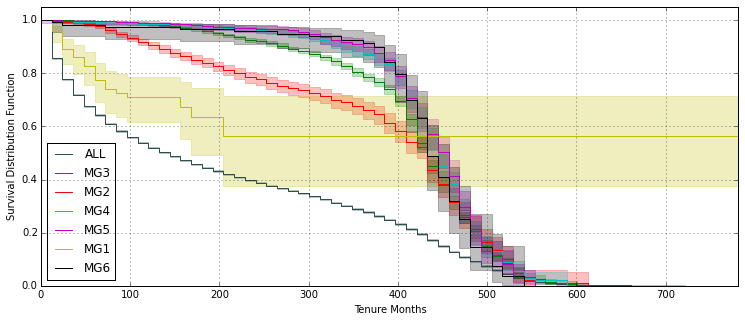

In [206]:
# create a dataFrame of these survival functions.


fig = plt.figure(figsize=(12.5,5))
#figsize(16,8)

top10grades = list(empltbl3.GRADE.value_counts()[:85].index)
kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3.Tenure_months, timeline=tenure_month_range, event_observed=empltbl3.status,label='ALL')
grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax=fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkslategray')
for grade in top10grades:
    
    #plt.figure(figsize=(20,10))
    em_grade = empltbl3[empltbl3.GRADE == grade]
    kmf_grade.fit(em_grade.Tenure_months, timeline=tenure_month_range,event_observed=em_grade.status,label=grade)
    if grade.startswith('MG'):
        kmf_grade.plot(ax=ax)
    grade_sf_df = pd.concat([grade_sf_df,kmf_grade.survival_function_],axis=1)
#kmf_gender.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
#kmf_gender.plot(ax=ax, c='deeppink',label='Female')

plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')


In [226]:
grade_sf_df.columns

Index([u'ALL', u'PA2', u'RB2', u'PA1', u'PA3', u'SF4', u'SF3', u'MA3', u'RA2', u'RA3', u'MG3', u'RB1', u'MA2', u'C3', u'MA1', u'PA4', u'SF5', u'NON', u'RC2', u'SF2', u'UNT', u'C4', u'RE3', u'RA4', u'MG2', u'RE4', u'PC3', u'MG4', u'C2', u'SF6', u'SF1', u'RA1', u'PB2', u'MA4', u'M2N', u'MA6', u'RC1', u'RB3', u'PB1', u'UES', u'PB3', u'C1', u'C5', u'MG5', u'RE2', u'M1N', u'MA5', u'FA5', u'LP1', u'B23', u'PC2', u'LS2', u'FA6', u'LS1', u'RC3', u'C6', u'FA3', u'PC4', u'C8', u'MA7', u'PB4', u'RD3', u'M3N', u'RD2', u'FA4', u'RD4', u'LS3', u'MA8', u'AG3', u'SF7', u'L7', u'MG1', u'RE1', u'RI3', u'C7', u'B01', u'RI2', u'MG6', u'FA2', u'RF1', u'L9', u'RL2', u'RG3', u'FA1', u'C23', u'L6'], dtype='object')

In [203]:
mgr = ((empltbl3.GRADE == 'MG2') |(empltbl3.GRADE == 'MG3') | (empltbl3.GRADE == 'MG4'))
sum(mgr)

9862

In [207]:
mgr = empltbl3.GRADE.isin(mg_codes)
sum(mgr)

10974

In [208]:
from lifelines.statistics import logrank_test
summary, p_value, test_results = logrank_test(empltbl3[mgr].Tenure_months, empltbl3[~mgr].Tenure_months, empltbl3[mgr].status, empltbl3[~mgr].status, alpha=.99 )
print summary

Results
   df: 1
   alpha: 0.99
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|__ test results __
         0.00000 |              7759.438 |     True   
Results
   df: 1
   alpha: 0.99
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|__ test results __
         0.00000 |              7759.438 |     True   


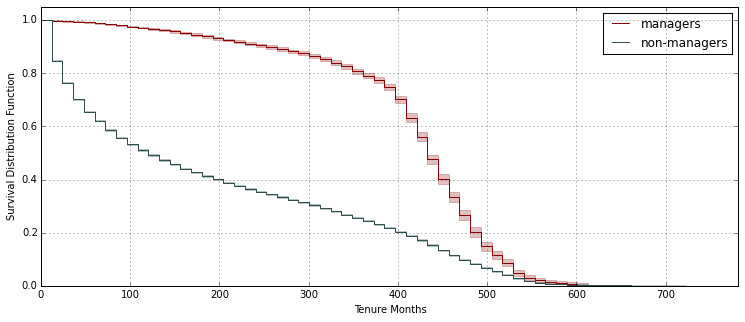

In [236]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[mgr].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[mgr].status,label='managers')
mgr_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~mgr].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~mgr].status,label='non-managers')
kmf_grade.plot(ax=ax,color='darkslategray')
mgr_sf_df = pd.concat([mgr_sf_df,kmf_grade.survival_function_],axis=1)
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

## BIGGER QUESTION IS whether this tenure is descriptive or proscriptive


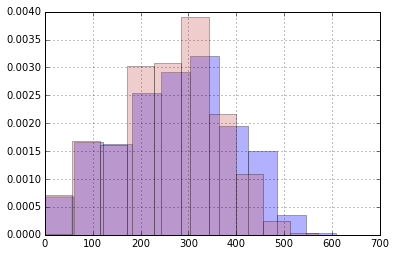

In [280]:
empltbl3[mgr].Tenure_months.hist(normed=True,alpha=0.3)
empltbl3[mgr][empltbl3.status==0].Tenure_months.hist(normed=True,color='indianred',alpha=.3)

## Take the set of employees that don't leave and calculate out their survival function in the future
* look at [1,10] years in the future for each.
* sum over all
* also get lower CL and upper CL
* divide sum by count to get % remaining.


In [281]:
mgr_sf_df.head(), len(mgr_sf_df)

(           managers  non-managers
 timeline                         
 0.000000   0.999909      0.999077
 12.023371  0.998266      0.847708
 24.046742  0.995699      0.764708
 36.070114  0.993574      0.702478
 48.093485  0.991337      0.655905, 66)

In [259]:
mgr_df = pd.DataFrame(empltbl3[mgr].Tenure_months)

In [267]:
[x for x in empltbl3[mgr][empltbl3.status==0].Tenure_months+12.0]

[202.7554569909033,
 89.373252017495233,
 330.62666584529455,
 118.12127559087456,
 273.59058707570995,
 175.12449947637529,
 96.962730240867373,
 371.10388303661267,
 311.7679623811577,
 319.09460153185898,
 280.03014435614693,
 340.97595433171114,
 29.807347173453255,
 90.75315714901744,
 258.57590504938503,
 174.04028830160783,
 297.7389268773486,
 339.3660650116019,
 47.746113883241954,
 175.38733854904618,
 368.80404115074231,
 331.94086120864904,
 177.45719624632949,
 119.73116491098379,
 314.7577568327892,
 52.345797654982647,
 352.70514794964987,
 172.85751247458879,
 212.87476128873283,
 164.57808168545554,
 249.67223146265837,
 360.52461036160906,
 104.32222427565247,
 274.05055545288405,
 431.12975625782872,
 251.28212078276761,
 281.57432390808845,
 91.180270642107644,
 195.69165691287296,
 111.87884761494075,
 131.46035852892257,
 138.35988418653361,
 196.54588389905336,
 279.57017597897288,
 223.91400234091049,
 265.08117209798968,
 299.80878457463194,
 409.51124253064745

In [290]:
mgr_sf_df.ix[:339.36].index[-1], mgr_sf_df.ix[339.36:].index[0]

(336.65439347198725, 348.67776466741537)

In [292]:
locate_closest_indices(mgr_sf_df, 339.36)

339.36 336.654393472 348.677764667


In [291]:
def locate_closest_indices(df,index_to_find):
    my_min = df.ix[:index_to_find].index[-1]
    my_max = df.ix[index_to_find:].index[0]
    #.index <= index_to_find
    #my_max = df.index >=index_to_find
    print index_to_find, my_min, my_max
    return my_min,my_max

In [318]:
def lin_interpolate(df,index_to_find,ycol):
    #x1,x2 = locate_closest_indices(df,x)
    my_min = df.ix[:index_to_find].index[-1]
    my_max = df.ix[index_to_find:].index[0]
    deltax = my_max-my_min
    #print my_min, my_max
    y_1 = df[ycol].ix[my_min]
    y_2 = df[ycol].ix[my_max]
    #print y_1, y_2
    
    deltay=df[ycol].ix[my_max]- y_1
    slope = deltay/deltax
    #print slope, deltax, deltay
    my_value = y_1+slope*(index_to_find-my_min)
    return my_value

In [311]:
mgr_sf_df.ix[mgr_sf_df.ix[:339.36].index[-1]:mgr_sf_df.ix[339.36:].index[0]]#.plot()#.interpolate()

,managers,non-managers
timeline,,
336.654393,0.825569,0.267808
348.677765,0.808117,0.256444


In [316]:
lin_interpolate(mgr_sf_df,339.36,'managers')

336.654393472 348.677764667
0.825568707522 0.808116527757
-0.00145152133134 12.0233711954 -0.0174521797648


0.82164146193264864

In [ ]:
index_to_find = 371.1

my_min = df['A'] <= value_to_find
Max = df['A'] >= value_to_find
idx_Min = df.ix[Min, 'A'].idxmax()
idx_Max = df.ix[Max, 'A'].idxmin()
df.ix[idx_Min:idx_Max, ['A','B']]

In [337]:
# add 1 to 10 years in to future
future_years_list = np.arange(1,11)
future_years_list*12.0

array([  12.,   24.,   36.,   48.,   60.,   72.,   84.,   96.,  108.,  120.])

In [319]:
plus_1yr = [lin_interpolate(mgr_sf_df,x,'managers') for x in empltbl3[mgr][empltbl3.status==0].Tenure_months+12.0]

In [322]:
len(plus_1yr)

7931

In [331]:
current_mgr.Tenure_months.values

array([ 190.75545699,   77.37325202,  318.62666585, ...,   82.72859812,
        378.88252326,  233.53251607])

In [336]:
future_year

9

In [338]:
## define a new data frame to hold the information
current_mgr = empltbl3[mgr][empltbl3.status==0].Tenure_months.copy()
#current_mgr.columns='Current_tenure'#,inplace=True)
new_df = pd.DataFrame()
for future_year in future_years_list:
    cname = 'plus_'+str(future_year)+'yr'
    survival_prob = [lin_interpolate(mgr_sf_df,x,'managers') for x in current_mgr.values+future_year*12.0]
    a_df = pd.DataFrame(survival_prob,columns=[cname])
    new_df = pd.concat([new_df,a_df],axis=1)
    
print new_df.shape

(7931, 10)


In [339]:
new_df.head()

,plus_1yr,plus_2yr,plus_3yr,plus_4yr,plus_5yr,plus_6yr,plus_7yr,plus_8yr,plus_9yr,plus_10yr
0,0.926295,0.919310,0.912766,0.906864,0.900004,0.892272,0.883410,0.876547,0.867044,0.854987
1,0.978011,0.973877,0.970189,0.965778,0.960416,0.954848,0.949109,0.942782,0.936018,0.929235
2,0.832759,0.816900,0.799761,0.782741,0.761055,0.725633,0.668895,0.598334,0.520011,0.440757
3,0.968665,0.963738,0.958185,0.952683,0.946694,0.940157,0.933270,0.926641,0.919683,0.913108
4,0.884287,0.877177,0.868018,0.856193,0.843239,0.829224,0.812598,0.795599,0.778494,0.754552


In [341]:
new_df.sum()/len(new_df)

plus_1yr     0.845019
plus_2yr     0.828616
plus_3yr     0.810554
plus_4yr     0.790342
plus_5yr     0.767734
plus_6yr     0.742550
plus_7yr     0.714848
plus_8yr     0.684948
plus_9yr     0.653099
plus_10yr    0.619969
dtype: float64

In [232]:
hold_df = mgr_sf_df.copy()

In [235]:
clvl_codes

['C2', 'C3', 'C5', 'C4', 'C1', 'C6', 'C8', 'C9', 'C23', 'C7', 'C01']

In [250]:
clvl = empltbl3.GRADE.isin(clvl_codes)
sum(clvl)

11909

In [255]:
sum(empltbl3[clvl].status==0)

0

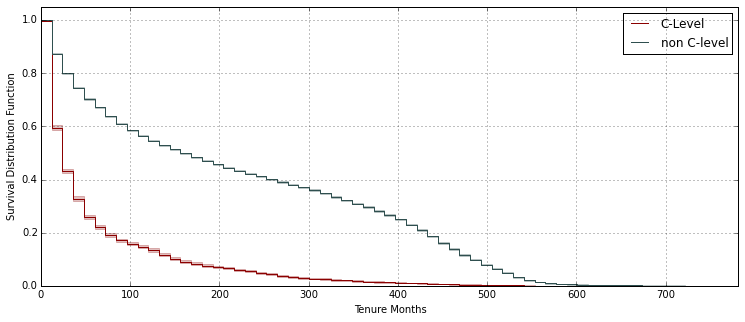

In [238]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[clvl].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[clvl].status,label='C-Level')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~clvl].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~clvl].status,label='non C-level')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

### look at different PA/RA

In [240]:
ra = empltbl3.GRADE.isin(ra_codes)
print sum(ra), ra_codes

16345 ['RA2', 'RA4', 'RA3', 'RA1']


In [243]:
rd = empltbl3.GRADE.isin(rd_codes)
print sum(rd), rd_codes
for code in rd_codes:
    print code,sum(empltbl3.GRADE == code)

940 ['RD2', 'RD3', 'RD4', 'RD1']
RD2 293
RD3 310
RD4 266
RD1 71


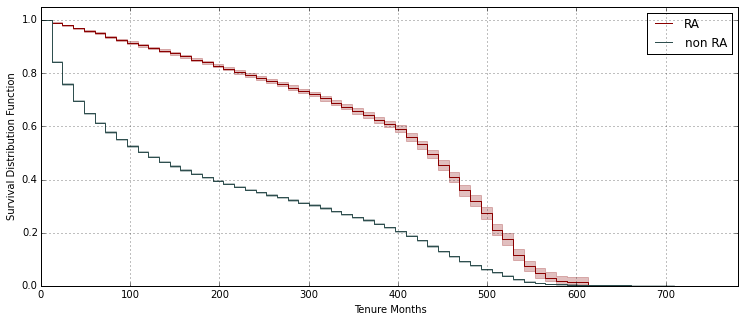

In [244]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[ra].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[ra].status,label='RA')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~ra].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~ra].status,label='non RA')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

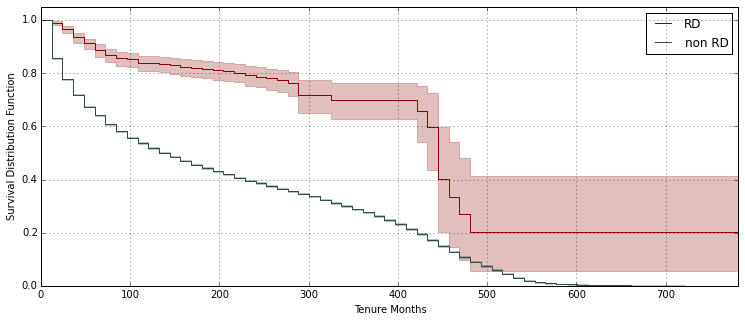

In [245]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[rd].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[rd].status,label='RD')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~rd].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~rd].status,label='non RD')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [249]:
re = empltbl3.GRADE.isin(re_codes)
print sum(re), re_codes

5411 ['RE4', 'RE3', 'RE2', 'RE1']


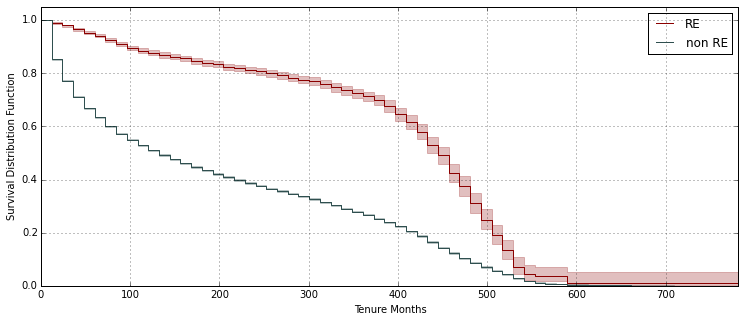

In [250]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[re].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[re].status,label='RE')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~re].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~re].status,label='non RE')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [247]:
pa = empltbl3.GRADE.isin(pa_codes)
print sum(pa), pa_codes

52276 ['PA1', 'PA3', 'PA2', 'PA4']


In [840]:
ma_codes

['MA1', 'MA3', 'MA4', 'MA2', 'MA7', 'MA5', 'MA6', 'MA8', 'MA9']

In [844]:
empltbl3[empltbl3.GRADE=='MG2'].JOBCODE.value_counts()

5086    309
0985    216
0986    211
2618    140
7982    119
0039    117
6210    116
0002     96
4103     90
1874     63
2100     60
2969     50
8081     47
2150     45
1028     43
...
7106    1
8553    1
0107    1
8923    1
3026    1
4281    1
8408    1
9830    1
5693    1
9905    1
4780    1
6094    1
8946    1
4147    1
6962    1
Length: 79, dtype: int64

In [845]:
empltbl3.JOBCODE.value_counts()

0090    11752
0036     7219
6200     5865
0057     5820
0167     5254
0061     5122
0089     4473
9930     3696
0068     3554
0214     3383
0067     3166
1876     3165
9999     2985
1009     2824
0500     2571
...
6158    1
6160    1
2216    1
2214    1
4517    1
9282    1
9425    1
9424    1
9426    1
5520    1
2304    1
4241    1
7306    1
7307    1
2291    1
Length: 3791, dtype: int64

In [ ]:
empltbl3[empltbl3['status'==1]].

In [839]:
empltbl3.JOB_FUNCTION.value_counts()

XXX    68899
PSA    52290
PTB    24750
PTA    15322
MGT    11111
NSA     6522
PTC     5268
PTE     5239
PSB     4173
PSC     3115
PTD      965
PTI      955
PTF      280
PTG      188
PTL      167
PTH      124
PTK       28
PTJ       21
PTM        2
dtype: int64

In [836]:
empl[empl.GRADE_MA1==1].status.value_counts()

1    3870
dtype: int64

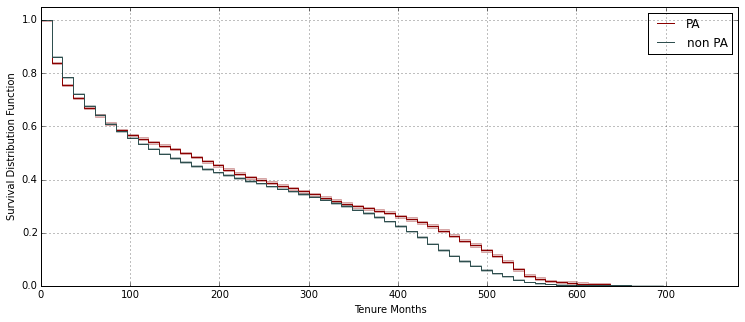

In [248]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[pa].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[pa].status,label='PA')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~pa].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~pa].status,label='non PA')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [253]:
pb = empltbl3.GRADE.isin(pb_codes)
print sum(pb), pb_codes

4152 ['PB1', 'PB3', 'PB2', 'PB4']


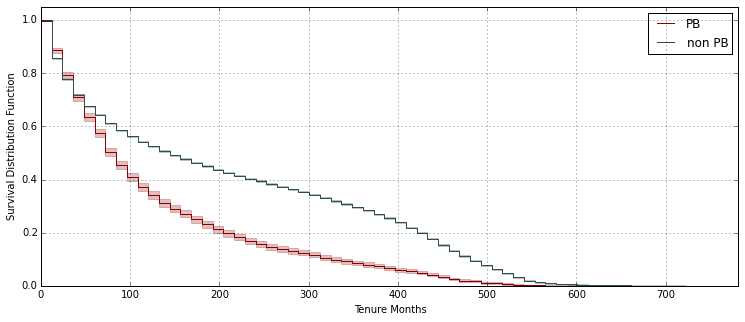

In [256]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[pb].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[pb].status,label='PB')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~pb].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~pb].status,label='non PB')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [254]:
sf = empltbl3.GRADE.isin(sf_codes)
print sum(sf), sf_codes

28683 ['SF5', 'SF3', 'SF4', 'SF2', 'SF6', 'SF1', 'SF7']


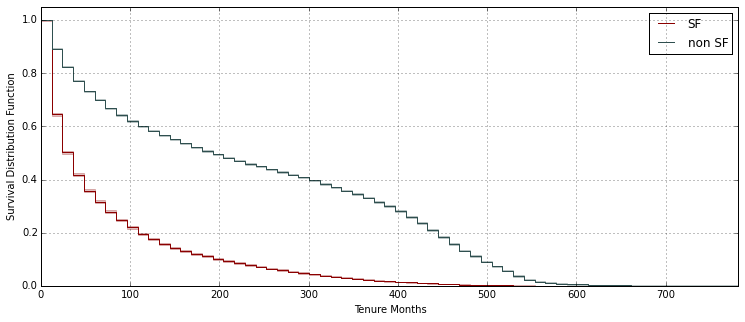

In [257]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[sf].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[sf].status,label='SF')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~sf].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~sf].status,label='non SF')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [276]:
sf_codes

['SF5', 'SF3', 'SF4', 'SF2', 'SF6', 'SF1', 'SF7']

In [255]:
ma = empltbl3.GRADE.isin(ma_codes)
print sum(ma), ma_codes

19416 ['MA1', 'MA3', 'MA4', 'MA2', 'MA7', 'MA5', 'MA6', 'MA8', 'MA9']


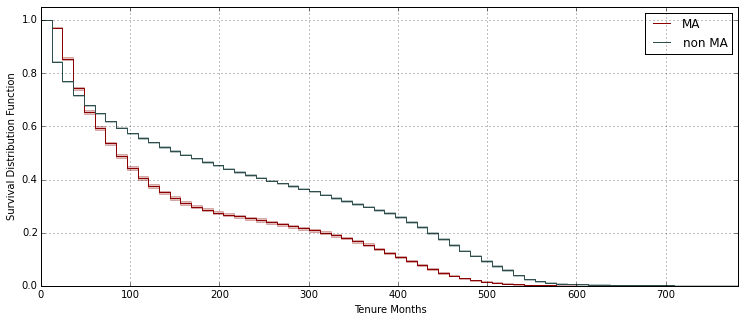

In [258]:
fig = plt.figure(figsize=(12.5,5))

kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3[ma].Tenure_months, timeline=tenure_month_range, event_observed=empltbl3[ma].status,label='MA')
#grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax = fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkred')
kmf_grade.fit(empltbl3[~ma].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[~ma].status,label='non MA')
kmf_grade.plot(ax=ax,color='darkslategray')
plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [247]:
pa = empltbl3.GRADE.isin(pa_codes)
print sum(pa), pa_codes

52276 ['PA1', 'PA3', 'PA2', 'PA4']


In [233]:
grade_sf_df.columns

Index([u'ALL', u'PA2', u'RB2', u'PA1', u'PA3', u'SF4', u'SF3', u'MA3', u'RA2', u'RA3', u'MG3', u'RB1', u'MA2', u'C3', u'MA1', u'PA4', u'SF5', u'NON', u'RC2', u'SF2', u'UNT', u'C4', u'RE3', u'RA4', u'MG2', u'RE4', u'PC3', u'MG4', u'C2', u'SF6', u'SF1', u'RA1', u'PB2', u'MA4', u'M2N', u'MA6', u'RC1', u'RB3', u'PB1', u'UES', u'PB3', u'C1', u'C5', u'MG5', u'RE2', u'M1N', u'MA5', u'FA5', u'LP1', u'B23', u'PC2', u'LS2', u'FA6', u'LS1', u'RC3', u'C6', u'FA3', u'PC4', u'C8', u'MA7', u'PB4', u'RD3', u'M3N', u'RD2', u'FA4', u'RD4', u'LS3', u'MA8', u'AG3', u'SF7', u'L7', u'MG1', u'RE1', u'RI3', u'C7', u'B01', u'RI2', u'MG6', u'FA2', u'RF1', u'L9', u'RL2', u'RG3', u'FA1', u'C23', u'L6'], dtype='object')

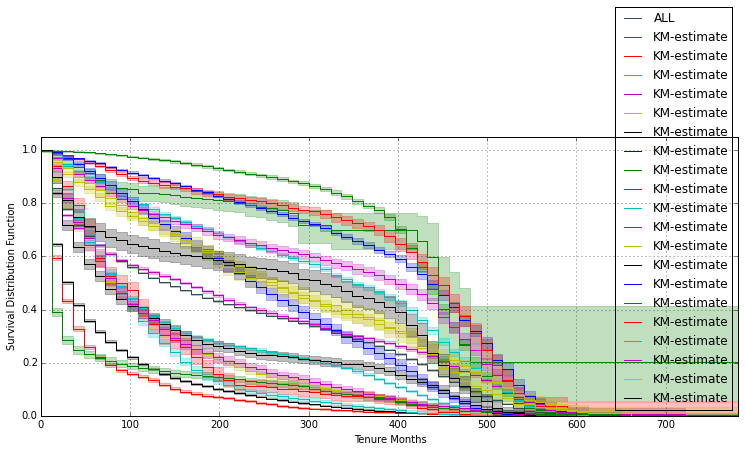

In [319]:
### More directly look at these 20 groupings:
# create a dataFrame of these survival functions.


fig = plt.figure(figsize=(12.5,5))
#figsize(16,8)

#grade_groups = #list(empltbl3.GRADE.value_counts()[:85].index)
kmf_grade=KaplanMeierFitter()

kmf_grade.fit(empltbl3.Tenure_months, timeline=tenure_month_range, event_observed=empltbl3.status,label='ALL')
gp_grade_sf_df = pd.DataFrame(kmf_grade.survival_function_)
ax=fig.add_subplot(111)
kmf_grade.plot(ax=ax,c='darkslategray')
for g in grade_groupings_list_A:
    
    #plt.figure(figsize=(20,10))
    gem_grade = empltbl3.GRADE.isin(g)
    kmf_grade.fit(empltbl3[gem_grade].Tenure_months, timeline=tenure_month_range,event_observed=empltbl3[gem_grade].status)#,label=grade)
    #if grade.startswith('MG'):
    kmf_grade.plot(ax=ax)
    gp_grade_sf_df = pd.concat([gp_grade_sf_df,kmf_grade.survival_function_],axis=1)
#kmf_gender.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
#kmf_gender.plot(ax=ax, c='deeppink',label='Female')

plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

#print sum(empltbl3.GRADE.isin(g)), g

In [325]:
gp_grade_sf_df.columns=['ALL','MG','C','MA','PA','PB','SF','RA','RD','RE','RB','RC','PC','L','FA', 'U', 'B', 'NON','M','R*','OTHR']#,inplace=True)
                               #mg_codes,clvl_codes,ma_codes,pa_codes,pb_codes,sf_codes, ra_codes,rd_codes,re_codes, rb_codes, rc_codes,
                          #pc_codes,l_codes,fa_codes, u_codes,b_codes,non_codes,m_codes,rx_codes,oth_codes

gp_grade_sf_df.head()

,ALL,MG,C,MA,PA,PB,SF,RA,RD,RE,...,RC,PC,L,FA,U,B,NON,M,R*,OTHR
timeline,,,,,,,,,,,,,,,,,,,,,
0.000000,0.999122,0.999909,0.997817,0.999845,0.998718,0.998314,0.998501,0.999939,1.000000,0.999630,...,1.000000,0.999679,1.000000,1.000000,0.994872,1.000000,1.000000,1.000000,1.000000,1.000000
12.023371,0.856099,0.998266,0.595180,0.971261,0.838874,0.886561,0.646341,0.990531,0.990870,0.990163,...,0.968791,0.955069,0.837227,0.991739,0.390146,0.939842,0.980739,0.932912,0.967350,0.899924
24.046742,0.777785,0.995699,0.432362,0.854501,0.757047,0.792871,0.502911,0.980148,0.966383,0.979687,...,0.941155,0.909416,0.718458,0.972006,0.285359,0.864321,0.940135,0.820047,0.934407,0.812230
36.070114,0.719193,0.993574,0.328071,0.742635,0.707193,0.709297,0.417111,0.969448,0.935188,0.965579,...,0.910374,0.878961,0.635490,0.945841,0.247947,0.794687,0.779542,0.730860,0.900280,0.747932
48.093485,0.675366,0.991337,0.259887,0.653945,0.669616,0.636561,0.357180,0.959764,0.912406,0.953015,...,0.888149,0.852160,0.572370,0.921465,0.231572,0.710775,0.686361,0.644436,0.874790,0.714142


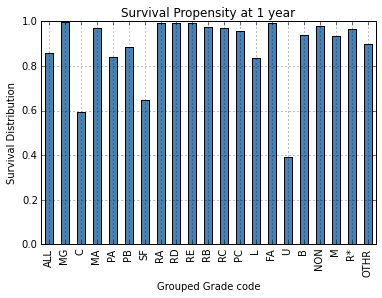

In [329]:
gp_grade_sf_df.iloc[1].plot(kind='bar',color='steelblue')
plt.title('Survival Propensity at 1 year')
plt.ylabel('Survival Distribution')
plt.xlabel('Grouped Grade code')

In [343]:
np.where(gp_grade_sf_df.ALL.values <=0.50)[0][0]

12

In [335]:
gp_grade_sf_df[gp_grade_sf_df['ALL']<=0.50].index[0]/12.


12.023371195428117

In [376]:
### Function to return the time when distribution falls to 50%
def find_Npct_survival(x,npct=0.50):
    first_index = np.where(x <=npct)[0][0]
    #ten_years = 
    print first_index, x.iloc[first_index], x.index[first_index]#.timeline
    #first_index-1
    #, x.iloc[first_index-1]
    return x.index[first_index]

In [377]:
gp_grade_sf_df['ALL'].index[12]

144.2804543451374

In [378]:
cnames = []
fiftyPCT = []
for c in gp_grade_sf_df.columns:
    cnames.append(c)
    fiftyPCT.append(find_Npct_survival(gp_grade_sf_df[c])/12.)#.apply(lambda x: find_Npct_survival(x))

12 0.486738088553 144.280454345
36 0.475976186859 432.841363035
2 0.4323620791 24.0467423909
7 0.487793572311 84.163598368
13 0.499680549609 156.303825541
7 0.455443159923 84.163598368
3 0.417111180839 36.0701135863
36 0.495708569011 432.841363035
37 0.403159409414 444.864734231
37 0.491058602562 444.864734231
29 0.495694935862 348.677764667
33 0.496069301337 396.771249449
22 0.485977083131 264.514166299
6 0.478798513011 72.1402271726
20 0.483886032946 240.467423909
1 0.390145837827 12.0233711954
7 0.498077387649 84.163598368
7 0.470588235294 84.163598368
7 0.463693764799 84.163598368
21 0.493677265974 252.490795104
26 0.497159772369 312.607651081


(0, 21)

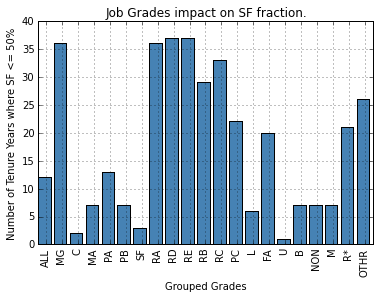

In [388]:
xvals= xrange(len(cnames))
h = plt.bar(xvals,fiftyPCT,color='steelblue')
plt.ylabel('Number of Tenure Years where SF <= 50%')
#plt.xlim(0,21)
plt.xlabel('Grouped Grades')
plt.title('Job Grades impact on SF fraction.')

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos,cnames,rotation='vertical')
plt.grid(True)
plt.xlim(0,21)

## TRY To look at how age effects sF
* bin this?

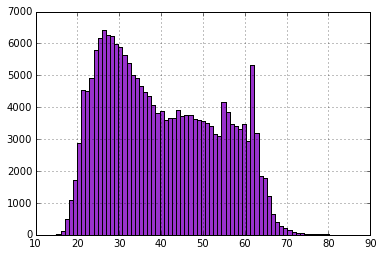

In [392]:
empltbl3.Age_years.hist(bins=70,range=[15,84],color='darkorchid')

In [391]:
empltbl3.Age_years.describe()

count    199419.000000
mean         40.210713
std          13.362226
min          15.263832
25%          28.594701
50%          38.207492
75%          51.445273
max          98.197773
dtype: float64

In [394]:
empltbl3.Age_years.head()

0    56.729433
1    21.322820
2    38.566158
3    62.963647
4    26.853392
Name: Age_years, dtype: float64

In [397]:
empltbl3['AgeGroup'] = pd.cut(empltbl3.Age_years,[0,24.5,34.5,44.5,54.5,64.5,100],labels=['0','1','2','3','4','5'])

0 23862
1 59053
2 40909
3 35735
4 35122
5 4602


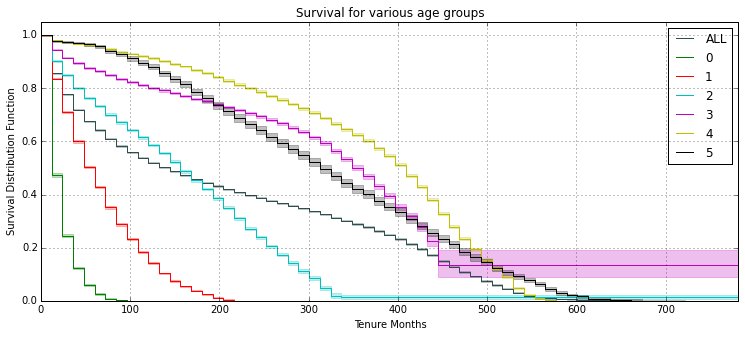

In [410]:
age_group_labels = ['0','1','2','3','4','5']
fig = plt.figure(figsize=(12.5,5))
kmf_agp = KaplanMeierFitter()
kmf_agp.fit(empltbl3.Tenure_months, timeline=tenure_month_range, event_observed=empltbl3.status,label='ALL')
    
age_gp_sf_df = pd.DataFrame(kmf_agp.survival_function_)
ax=fig.add_subplot(111)
kmf_agp.plot(ax=ax,c='darkslategray')

for ag in age_group_labels:
    age_group = empltbl3[empltbl3.AgeGroup == ag]
    print ag, len(age_group)
    
    
        
    kmf_agp.fit(age_group.Tenure_months, timeline=tenure_month_range,event_observed=age_group.status,label=ag)
    
    kmf_agp.plot(ax=ax)
    age_gp_sf_df = pd.concat([age_gp_sf_df,kmf_grade.survival_function_],axis=1)

plt.ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')
plt.title('Survival for various age groups')

#print sum(empltbl3.GRADE.isin(g)), g

'TRANSFER W/O JOB NUMBER CHANGE;COMPANY WIDE CONVERSION;REGIONAL CONVERSION;MISCELLANEOUS DATA CHANGE;COST OF LIVING ADJUSTMENT;MERIT'

In [411]:
age_gp_sf_df.columns = ['ALL','0to25','25to35','35to45','45to55','55to65','65to100']#+=age_group_labels
age_gp_sf_df.head()

,ALL,0to25,25to35,35to45,45to55,55to65,65to100
timeline,,,,,,,
0.000000,0.999122,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
12.023371,0.856099,0.899924,0.899924,0.899924,0.899924,0.899924,0.899924
24.046742,0.777785,0.812230,0.812230,0.812230,0.812230,0.812230,0.812230
36.070114,0.719193,0.747932,0.747932,0.747932,0.747932,0.747932,0.747932
48.093485,0.675366,0.714142,0.714142,0.714142,0.714142,0.714142,0.714142


ValueError: num must be 0 <= num <= 6, not 7

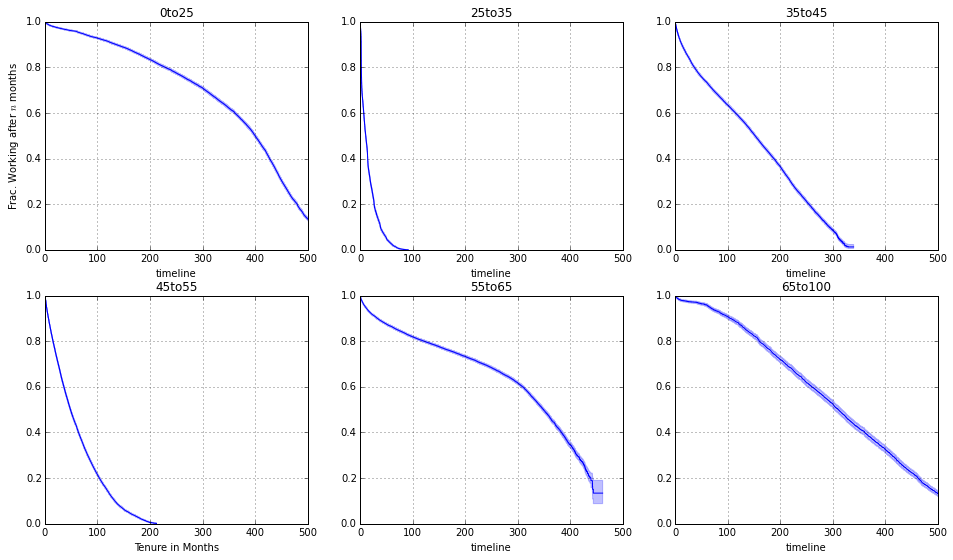

In [421]:
age_grp_types = empltbl3.AgeGroup.unique()
kmf= KaplanMeierFitter()
fig = plt.figure(figsize=(16,9))

for i,agp_type in enumerate(age_grp_types):
    ax = plt.subplot(2,3,i+1)
    ix = empltbl3['AgeGroup'] == agp_type
    kmf.fit( empltbl3[ix].Tenure_months, empltbl3[ix].status, label=age_gp_sf_df.columns[i+1])
    kmf.plot(ax=ax, legend=False)
    plt.title(age_gp_sf_df.columns[i+1])
    plt.xlim(0,500)
    if i==0:
        plt.ylabel('Frac. Working after $n$ months')
    if i == 3:
        plt.xlabel("Tenure in Months")
plt.tight_layout()

In [426]:
sdf[sdf.Column.isin(cols_to_categorical)]

,Column,datatype,nmissing,arity,accepted values,x_missing,y_arity
29,COMPANY,object,0,7,"[005, 001, 002, 049, 007, 003, 004]",0,2.87881e-05
30,COMP_FREQUENCY,object,0,2,"[A, H]",0,8.225172e-06
42,DIVISION_CODE_SFI,object,15,10,"[1, 9, 0, 7, 2, 5, 3, 4, 6, nan]",7.521851e-05,4.112586e-05
43,EEO1CODE,object,0,11,"[2, 5, 1, 3, 7, 4, N, 6, 8, L, 9]",0,4.523845e-05
48,EMPL_CLASS,object,0,12,"[1, 3, D, T, O, 4, P, X, F, 5, 2, G]",0,4.935103e-05
49,EMPL_TYPE,object,0,5,"[E, H, S, N, X]",0,2.056293e-05
50,ETHNIC_GROUP,float64,0,8,"[1.0, 2.0, 3.0, 4.0, 8.0, 5.0, 7.0, 6.0]",0,3.290069e-05
58,FLSA_STATUS,object,0,3,"[N, Z, X]",0,1.233776e-05
64,FULLPART1,object,0,2,"[N, Y]",0,8.225172e-06
68,FULL_PART_TIME,object,0,4,"[F, P, N, X]",0,1.645034e-05


## this was descriptive, how to make it predictive?

Try using `AalenAdditiveFitter`

In [213]:
from lifelines import AalenAdditiveFitter
import patsy

In [214]:
X = patsy.dmatrix('Age_years + COMPANY + INTERN + SEX',empltbl4, return_type='dataframe')
X.columns


Index([u'Intercept', u'COMPANY[T.002]', u'COMPANY[T.003]', u'COMPANY[T.004]', u'COMPANY[T.005]', u'COMPANY[T.007]', u'COMPANY[T.049]', u'Age_years', u'INTERN', u'SEX'], dtype='object')

In [215]:
aaf = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
X['T'] = empltbl4['Tenure_years']
X['E'] = empltbl4['status']

In [216]:
aaf.fit(X,'T','E')

 [-----------------100%-----------------] 129614 of 129613 complete in 5543.3 sec


<lifelines.AalenAdditiveFitter: fitted with 199419 observations, 69806 censored>

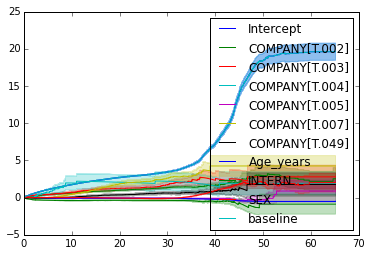

In [219]:
aaf.plot()

In [275]:
aaf.cumulative_hazards_.loc[40:]

,Intercept,COMPANY[T.002],COMPANY[T.003],COMPANY[T.004],COMPANY[T.005],COMPANY[T.007],COMPANY[T.049],Age_years,INTERN,SEX,baseline
40.000821,7.218942,1.649324,2.338103,1.545120,-0.136833,4.252642,0.863320,-0.223179,-0.549751,0.928479,7.218942
40.003559,7.222968,1.648837,2.337367,1.544521,-0.134269,4.252642,0.862675,-0.223302,-0.550514,0.929681,7.222968
40.006297,7.230071,1.675036,2.336645,1.543856,-0.135599,4.252642,0.861387,-0.223511,-0.551749,0.930385,7.230071
40.009035,7.234180,1.674991,2.336441,1.543606,-0.134297,4.252642,0.861077,-0.223641,-0.552149,0.931096,7.234180
40.014511,7.251082,1.674157,2.335129,1.542272,-0.132996,4.252642,0.859181,-0.224163,-0.554028,0.933924,7.251082
40.017249,7.253167,1.673112,2.335028,1.542173,-0.134584,4.252642,0.857834,-0.224199,-0.530061,0.932274,7.253167
40.019987,7.259380,1.672776,2.334257,1.541487,-0.135233,4.252642,0.900663,-0.224395,-0.530404,0.933977,7.259380
40.022725,7.262802,1.672147,2.333064,1.540596,-0.135885,4.252642,0.900089,-0.224503,-0.530596,0.935963,7.262802
40.025463,7.268293,1.671103,2.331894,1.539676,-0.137221,4.252642,0.898853,-0.224663,-0.531615,0.937219,7.268293
40.028200,7.270403,1.670691,2.331924,1.539650,-0.137905,4.252642,0.898192,-0.224716,-0.532443,0.936486,7.270403


In [223]:
aaf.

<bound method AalenAdditiveFitter.fit of <lifelines.AalenAdditiveFitter: fitted with 199419 observations, 69806 censored>>

In [431]:
#X = patsy.dmatrix('SEX + AgeGroup + INTERN + DIVISION_CODE_SFI -1', empltbl3, return_type='dataframe')
X = patsy.dmatrix('AgeGroup + INTERN -1', empltbl3, return_type='dataframe')
X.columns

Index([u'AgeGroup[0]', u'AgeGroup[1]', u'AgeGroup[2]', u'AgeGroup[3]', u'AgeGroup[4]', u'AgeGroup[5]', u'AgeGroup[6]', u'INTERN[T.Y]'], dtype='object')

In [432]:
aaf = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
X['T'] = empltbl3['Tenure_years']
X['E'] = empltbl3['status']

In [433]:
aaf.fit(X,'T','E')

 [-----------------100%-----------------] 129613 of 129613 complete in 4422.5 sec


<lifelines.AalenAdditiveFitter: fitted with 199419 observations, 69806 censored>

In [434]:
aaf.cumulative_hazards_.head()

,AgeGroup[0],AgeGroup[1],AgeGroup[2],AgeGroup[3],AgeGroup[4],AgeGroup[5],AgeGroup[6],INTERN[T.Y],baseline
0.000000,0.000878,0.000732,0.000481,0.000020,-0.000377,-0.000579,-0.000559,-0.001075,0.000595
0.002738,0.001677,0.001164,0.000808,-0.000085,-0.000730,-0.000802,-0.000985,-0.001825,0.001046
0.005476,0.002449,0.001482,0.001056,-0.000134,-0.001053,-0.000835,-0.001440,-0.002545,0.001525
0.008214,0.003060,0.001853,0.001168,-0.000123,-0.001255,-0.000992,-0.001803,-0.003145,0.001909
0.010952,0.004493,0.002249,0.001550,-0.000157,-0.001713,-0.001566,-0.002359,-0.004099,0.002497


### Plot the Estimates of cumulative $\beta_i$

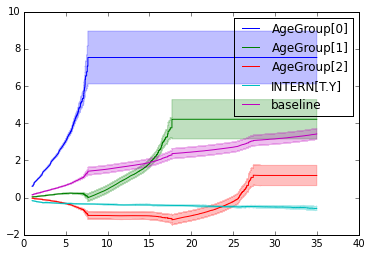

In [438]:
aaf.plot( columns=[ 'AgeGroup[0]','AgeGroup[1]','AgeGroup[2]','INTERN[T.Y]', 'baseline' ], ix=slice(1,35) )

## try to predict someone's tenure

In [469]:
ix = (empltbl3['AgeGroup'] == '0')
ib = (empltbl3['AgeGroup'] == '2')
#harper = X[ix,:][-1,:][None,:]
#harper[0,-1] = 2003
#print "Harper's unique data point"

In [465]:
X[ix].iloc[[0,2],0:-2]

,AgeGroup[0],AgeGroup[1],AgeGroup[2],AgeGroup[3],AgeGroup[4],AgeGroup[5],AgeGroup[6],INTERN[T.Y]
1,1,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,1


In [473]:
X[ib].iloc[20:25]#,0:-2]

,AgeGroup[0],AgeGroup[1],AgeGroup[2],AgeGroup[3],AgeGroup[4],AgeGroup[5],AgeGroup[6],INTERN[T.Y],T,E
123,0,0,1,0,0,0,0,0,20.419310,0
128,0,0,1,0,0,0,0,1,3.411432,1
130,0,0,1,0,0,0,0,0,15.551312,0
131,0,0,1,0,0,0,0,0,3.066456,1
134,0,0,1,0,0,0,0,0,12.660082,1


In [451]:
test1 = X[ix].iloc[0] 
test2 = X[ix].iloc[2]

In [456]:
test2.values

array([ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  2.57637049,  0.        ])

(0, 10)

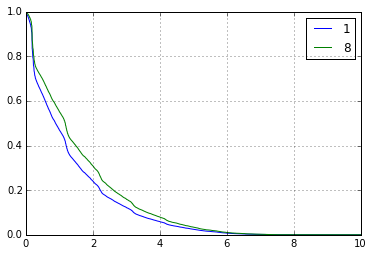

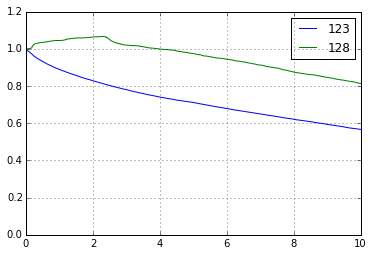

In [475]:
aaf.predict_survival_function(X[ix].iloc[[0,2],0:-2]).plot()
plt.xlim(0,10)
aaf.predict_survival_function(X[ib].iloc[[20,21],0:-2]).plot()
plt.xlim(0,10)

ValueError: need more than 1 value to unpack

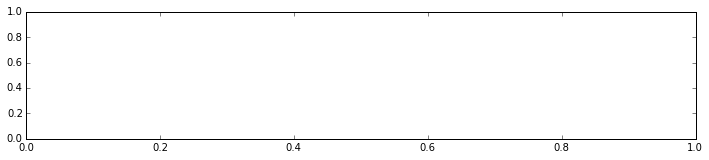

In [455]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(2,1,1)
aaf.predict_cumulative_hazard(test1.values).plot(ax=ax)

In [117]:
[x for x in sdf.Column if x.startswith('JOB')]

['JOBCNT1',
 'JOBCNT10',
 'JOBCNT3',
 'JOBCNT5',
 'JOBCODE',
 'JOB_FAMILY',
 'JOB_FUNCTION']

In [133]:
sdf[sdf.Column == 'GRADE']

,Column,datatype,nmissing,arity,accepted values,x_missing,y_arity
75,GRADE,object,526,164,None,0.002637662,0.0006744641


In [ ]:
current.GRADE.value_counts()

# Construct a graph out of the active employees
* use the index from the dataframe as the node number

In [ ]:
import networkx as nx
G=nx.DiGraph()


In [ ]:
#initialize with the ceo index
#initialize with the ceo index
#initialize with the ceo index
ceo_index = list(current[current.KEY==ceo_key].index)[0]
print ceo_index,ceo_key
G.add_node(ceo_index)
G.graph

In [ ]:
def id_dependents(

In [ ]:
# now apply some logic to these columns for keeping and not
columns_to_fix_missing = []
columns_to_fix_NY = []
columns_to_omit = []

In [ ]:
columns_to_fix_missing

In [ ]:
len(sdf[sdf['datatype']=='object'])

In [ ]:
sdf[(sdf['datatype']=='object') & (sdf['x_missing']<=missing_threshold) & (sdf['x_missing'] > 0)]

In [127]:
empltbl3[empltbl3.STATE == 'NB'][['status','LOC_STATE','LOC_CITY','JOB_FUNCTION']]#,'zip5']]

,status,LOC_STATE,LOC_CITY,JOB_FUNCTION
63295,1,MO,COLUMBIA,NaN
91843,1,MO,COLUMBIA,NaN
123438,1,CA,ROHNERT PARK,NaN


In [ ]:
sdf.head()

In [ ]:
empltbl[empltbl.POSTAL_SFI.isnull()].zip5

In [ ]:
empltbl.ACTRES1.tail()

In [ ]:
# omit those that have more than 40% missing:
columns_to_omit = sdf[sdf['x_missing'] > missing_threshold].Column.values
print len(columns_to_omit)
columns_to_omit

In [ ]:
pd.crosstab(empltbl['HUBIND'],empltbl['SUPV_DIFF_LOC'])

In [ ]:
empltbl.FLSA_STATUS.value_counts()

In [ ]:
empltbl.JOB_FAMILY.value_counts()[empltbl.JOB_FAMILY.value_counts()>100]

In [ ]:
sort(columns_to_keep)

In [ ]:
reduced_tbl = empltbl[columns_to_keep].copy()
reduced_tbl.shape

In [ ]:
## drop those that are not VOL or NOT in VOLINVOL column
sum(reduced_tbl.isin({'VOLINVOL':['NOT','VOLUNTARY']}))

In [ ]:
for cat_col in cols_to_categorical:
    reduced_tbl[cat_col] = reduced_tbl[cat_col].astype('category')


In [ ]:
reduced_summary_df = summarize_dataframe2(red_tbl)

In [ ]:
reduced_tbl.head()

In [ ]:
reduced_tbl.columns

In [ ]:
pd.crosstab(reduced_tbl['REMOTE'],reduced_tbl['HUBIND'])

In [ ]:
pd.crosstab(reduced_tbl['FTPTCNT1'],reduced_tbl['PTFTCNT1'])

In [ ]:
reduced_tbl.FULL_PART_TIME.value_counts()

In [ ]:
## further reduce by removing
FULL_PART_TIME, ACTRES1, KEY, 

In [ ]:
len(reduced_tbl.JOB_FAMILY.unique()), len(reduced_tbl.JOB_FUNCTION.unique()), len(reduced_tbl.GRADE.unique()),len(reduced_tbl.JOBCODE.unique())

In [ ]:
reduced_tbl.JOB_FUNCTION.value_counts().plot(kind='bar',color='burlywood')

In [ ]:
reduced_tbl.GRADE.value_counts().plot(kind='bar',color='burlywood')

In [ ]:
#sum(reduced_tbl.MAX_RT_ANNUAL==0)
reduced_tbl[reduced_tbl.ANNUAL_RT!=0].ANNUAL_RT.hist(bins=40,color='darkorchid')

In [ ]:
sum(reduced_tbl.ANNUAL_RT==0)

In [ ]:
reduced_tbl['JOB_FUNCTION'].unique()

In [ ]:
initial_columns_list = ['SEX','INTERN','FULL_PART_TIME']#,'COMPANY','VOLINVOL']#'JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']
sum(reduced_tbl[initial_columns_list].isnull())

In [ ]:
jf_hold = reduced_tbl.JOB_FUNCTION.astype('object')
jf_hold.fillna('XXX',inplace=True)
reduced_tbl['JOB_FUNCTION'] = jf_hold
reduced_tbl['JOB_FUNCTION'] = reduced_tbl['JOB_FUNCTION'].astype('category')

In [ ]:
initial_columns_list = ['SEX','Age_years','INTERN','FULL_PART_TIME','JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']
sum(reduced_tbl[initial_columns_list].isnull())

In [ ]:
#pull out the reduced columns
fill_flag = True
reduced2 = reduced_tbl[initial_columns_list].copy()
for c in reduced2.columns:
    nmissing = sum(reduced2[c].isnull())
    datatype = reduced2[c].dtype
    if nmissing > 0 and fill_flag:
        if datatype=='category':
            reduced2[c].fillna('XNA',inplace=True)
    
        
    print c, reduced2[c].dtype

In [ ]:
reduced2 = reduced_tbl[initial_columns_list].copy()
reduced2.shape

In [ ]:
dummy_columns_list1 = list(reduced2.columns) #['SEX','INTERN','FULL_PART_TIME','JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']

In [ ]:
# create a dummified dataframe.
reduced_dummies = pd.get_dummies(reduced2[dummy_columns_list1])
print reduced_dummies.shape    

In [ ]:
dummy_column_list2 = list(reduced_dummies.columns)

In [ ]:
dummy_col_to_drop = []
for col in dummy_columns_list1:
    dclist = [x for x in dummy_column_list2 if x.startswith(col)]
    print dclist
    dummy_col_to_drop.append(dclist[0])

dummy_col_to_keep = list(set(dummy_column_list2) - set(dummy_col_to_drop))

reduced3 = reduced_dummies[dummy_col_to_keep].copy()
#add the non-categorical back in
#reduced3[initial_columns_list[1]] = reduced2[initial_columns_list[1]]
reduced3.shape

In [ ]:
## add in status and time
reduced3['Age'] = empltbl['Age_years']
reduced3['status'] = empltbl['status']
reduced3['Tenure'] = empltbl['Tenure_months']

## Aalen's Additive model

In [ ]:
from lifelines import AalenAdditiveFitter
reduced3.head()

In [ ]:
reduced3.columns

In [ ]:
aaf_tenure = AalenAdditiveFitter(penalizer=1.0,fit_intercept=True)

In [ ]:
aaf_tenure.fit(reduced3,'Tenure',event_col='status')

In [ ]:
aaf_tenure.plot(columns=['FULL_PART_TIME_P','Age','SEX_M','baseline'])

In [ ]:
aaf_tenure_b = AalenAdditiveFitter(penalizer=1.0,fit_intercept=True)

In [ ]:
aaf_tenure_b.fit(reduced3,'Tenure',event_col='status')

## CoxPH

In [ ]:
from lifelines import CoxPHFitter

In [ ]:
cf_tenure = CoxPHFitter()
cf_tenure.fit(reduced3,'Tenure',event_col='status')


In [ ]:
cf_tenure.summary()

In [ ]:
cf_tenure.plot(columns=['FULL_PART_TIME_P','Age','SEX_M','baseline'])

In [ ]:
cf_tenure.hazards_

In [ ]:
cf_tenure.baseline_cumulative_hazard_.plot()

In [ ]:
cf_tenurereenure.base

In [ ]:
reduced3.index = np.arange(0,len(reduced3))

In [ ]:
# k-fold

from lifelines.utils import k_fold_cross_validation

#regression_dataset = load_regression_dataset()
cf = CoxPHFitter()
scores = k_fold_cross_validation(cf, reduced3, 'Tenure', event_col='status', k=5)
print scores
print scores.mean()
print scores.std()

In [ ]:
import patsy

In [ ]:
X = patsy.dmatrix('SEX + JOB_FUNCTION + Age_years + INTERN + COMPANY + VOLINVOL + HUBIND - 1', reduced2, return_type='dataframe')

In [ ]:
patsy.__version__

In [ ]:
# now use lifelines
from lifelines import KaplanMeierFitter

In [ ]:
figsize(14,6)
kmf = KaplanMeierFitter()
kmf.fit(empltbl.Tenure_months, event_observed=empltbl.status)
kmf.plot()
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure months')
plt.title('KaplanMeier Survival: ALL employees')

In [ ]:
kmf.survival_function_

### look at difference between M & F

In [ ]:
male = empltbl[empltbl['SEX'] =='M']
female = empltbl[empltbl['SEX'] =='F']
len(male),len(female)

In [ ]:
male.Tenure_months.describe(), female.Tenure_months.describe()

In [ ]:
min_tenure_months= empltbl.Tenure_months.min()
max_tenure_months = empltbl.Tenure_months.max()
print min_tenure_months, max_tenure_months
tenure_month_range = np.linspace(min_tenure_months,max_tenure_months,65)
len(tenure_month_range)

In [ ]:
male.Tenure_months.hist(normed=True,color='dodgerblue',bins=65,label='M')
female.Tenure_months.hist(normed=True,color='deeppink',alpha=0.5,bins=65,label='F')
plt.xlabel('Tenure_months')
plt.ylabel('Normed Distribution')
plt.legend()

In [ ]:
kmf_gender = KaplanMeierFitter()
#plt.figure(figsize=(20,10))
kmf_gender.fit(male.Tenure_months, timeline=tenure_month_range,event_observed=male.status)
ax = kmf_gender.plot(c='dodgerblue',label='Male')
kmf_gender.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
kmf_gender.plot(ax=ax, c='deeppink',label='Female')
ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

## Hazard Function

In [ ]:
from lifelines import NelsonAalenFitter
#plt.figure(figsize=(12.5,8))
naf = NelsonAalenFitter()
naf.fit(male.Tenure_months,timeline=tenure_month_range, event_observed=male.status)
ax = naf.plot(c='dodgerblue',label='Male')
naf.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
naf.plot(ax=ax, c='deeppink',label='Female')
#ylim(0,1.05)
plt.ylabel('Hazard Function')
plt.xlabel('Tenure Months')
#fit(male.Tenure_months,timeline=tenure_month_range, event_observed=male.status)

### Repeat using age in years as timeline

In [ ]:
empltbl.Age_years.describe()

In [ ]:
sum(empltbl.Age_years > 80)

In [ ]:
min_age = empltbl.Age_years.min()
max_age = empltbl.Age_years.max()
print min_age, max_age, max_age - min_age
delta_age= int(max_age - min_age)
age_range = np.linspace(min_age,max_age,delta_age)
len(age_range)

In [ ]:
kmf_age = KaplanMeierFitter()
kmf_age.fit(empltbl.Age_years, timeline=age_range,event_observed=empltbl.status)
kmf_age.plot(color='darkgoldenrod')
plt.ylabel('Survival Distribution Function')

In [ ]:
male.Age_years.hist(normed=True,color='dodgerblue',bins=82,alpha=0.7,label='M')
female.Age_years.hist(normed=True,color='deeppink',alpha=0.3,bins=82,label='F')
plt.xlabel('Age_years')
plt.ylabel('Normed Distribution')
plt.legend()

In [ ]:
kmf_gender_age = KaplanMeierFitter()
#plt.figure(figsize=(20,10))
kmf_gender_age.fit(male.Age_years, timeline=age_range,event_observed=male.status)
ax = kmf_gender_age.plot(c='dodgerblue',label='Male')
kmf_gender_age.fit(female.Age_years,  timeline=age_range,event_observed=female.status)
kmf_gender_age.plot(ax=ax, c='deeppink',label='Female')
ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Age (years)')
plt.title('Gender-split KM')

## Cox Proportional Hazard Regression


In [ ]:
from lifelines import CoxPHFitter

In [ ]:
plt.scatter(empltbl.FLOORCNT1,empltbl.DEPTCNT1,color='burlywood',alpha=0.3)

In [ ]:
#pd.crosstab(empltbl, index = 'JOBCNT1',columns =
#(empltbl, 
empltbl[['JOBCNT1','LOCCNT1','DEPTCNT1','GRADECNT1','FLOORCNT1','SUPVCNT1']].corr()

In [ ]:
c='EMPL_CLASS'
empltbl[c].value_counts()

In [ ]:

len(empltbl[c].unique())

In [ ]:
plt.scatter(empltbl.ANNUAL_RT,empltbl.SAL1,color='burlywood',alpha=0.3)
empltbl[['ANNUAL_RT','SAL1']].corr()

In [ ]:
len(empltbl[empltbl.ANNUAL_RT>0])

In [ ]:
np.log(empltbl.ANNUAL_RT+1).hist(bins=30)

In [ ]:
empltbl.SAL1.hist(bins=80)
empltbl.SAL1.describe()

In [ ]:
sum(empltbl.SAL1 == 0.0)

In [ ]:
empltbl.RELOCATE_ALL_SFI.value_counts()

In [ ]:
empltbl.LOCATION.value_counts().hist(bins=50)

In [ ]:
empltbl.LOC_STATE.unique()

## encode some of the categorical columns

## Per discussion with HR TEAM on April 22, 2015

In [425]:
empl = empltbl4[empltbl4.sep_status<=2] # Remove the OTHER & UNKNOWN reasons

In [426]:
empl.shape

(198599, 70)

In [427]:
# look at the list of ACTRES1 for  ReTIREMENT
uniq_action_reasons_1 = empl.ACTRES1.unique()
print len(uniq_action_reasons_1)
#ret_action_reasons_1 = [x for x in uniq_action_reasons_1 if 'RETIREMENT' in x]
#print len(ret_action_reasons_1)

25482


In [432]:
temp_list = [x.split(';') for x in uniq_action_reasons_1]
from itertools import chain
act_reason_1_list = list(chain.from_iterable(temp_list))
print len(act_reason_1_list)

143036


In [433]:
act_reason_1_set = set(act_reason_1_list)

In [435]:
len(act_reason_1_set)

191

In [444]:
[x for x in act_reason_1_set if 'DISABI' in x]

['RETURN FROM DISABILITY', 'DISABILITY', 'WAIVE PREMIUM DUE TO DISABILTY']

In [445]:
#possible_retire_codes = 
possible_retire_codes = [x for x in act_reason_1_set if ('RET' in x and  'RETURN' not in x) ]
possible_retire_codes.append('DISABILITY')
len(possible_retire_codes)

23

In [449]:
possible_retire_codes.sort()

In [450]:
possible_retire_codes

['DISABILITY',
 'EARLY RETIREMENT',
 'NORMAL RETIREMENT',
 'PART-TIME RETIREE',
 'PART-TIME RETIREE - NO GI',
 'REGULAR RETIREMENT',
 'RET W/ INVOLUNTARY SEVERANCE',
 'RET W/ VOLUNTARY SEVERANCE',
 'RETIREE',
 'WINDOW 0 - EARLY RET INCENTIVE',
 'WINDOW 0 - RET WITH INVOL SEV',
 'WINDOW 1 - EARLY RET INCENTIVE',
 'WINDOW 1 - RET WITH INVOL SEV',
 'WINDOW 2 - EARLY RET INCENTIVE',
 'WINDOW 2 - RET WITH INVOL SEV',
 'WINDOW 3 - EARLY RET INCENTIVE',
 'WINDOW 3 - RET WITH INVOL SEV',
 'WINDOW 4 - EARLY RET INCENTIVE',
 'WINDOW 4 - RET WITH INVOL SEV',
 'WINDOW 5 - EARLY RET INCENTIVE',
 'WINDOW 5 - RET WITH INVOL SEV',
 'WINDOW 6 - EARLY RET INCENTIVE',
 'WINDOW 6 - RET WITH INVOL SEV']

In [457]:
t1 = empl.ACTRES1.ix[1]
[a for a in t1.split(';') if a in possible_retire_codes ]

[]

In [584]:
possible_retire_codes

['DISABILITY',
 'EARLY RETIREMENT',
 'NORMAL RETIREMENT',
 'PART-TIME RETIREE',
 'PART-TIME RETIREE - NO GI',
 'REGULAR RETIREMENT',
 'RET W/ INVOLUNTARY SEVERANCE',
 'RET W/ VOLUNTARY SEVERANCE',
 'RETIREE',
 'WINDOW 0 - EARLY RET INCENTIVE',
 'WINDOW 0 - RET WITH INVOL SEV',
 'WINDOW 1 - EARLY RET INCENTIVE',
 'WINDOW 1 - RET WITH INVOL SEV',
 'WINDOW 2 - EARLY RET INCENTIVE',
 'WINDOW 2 - RET WITH INVOL SEV',
 'WINDOW 3 - EARLY RET INCENTIVE',
 'WINDOW 3 - RET WITH INVOL SEV',
 'WINDOW 4 - EARLY RET INCENTIVE',
 'WINDOW 4 - RET WITH INVOL SEV',
 'WINDOW 5 - EARLY RET INCENTIVE',
 'WINDOW 5 - RET WITH INVOL SEV',
 'WINDOW 6 - EARLY RET INCENTIVE',
 'WINDOW 6 - RET WITH INVOL SEV']

In [458]:
def identify_retired(x,ret_codes =possible_retire_codes):
    matched = [a for a in x.split(';') if a in ret_codes]
    if len(matched):
        return 1
    else:
        return 0

In [460]:
empl['retired'] = empl.ACTRES1.apply(lambda x: identify_retired(x))

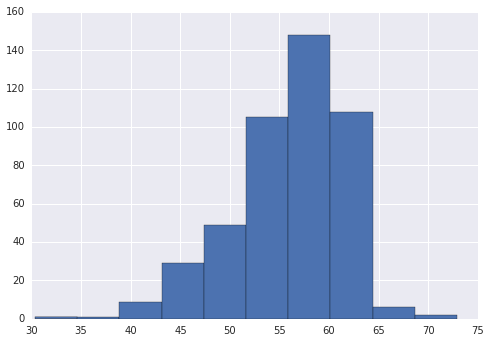

In [487]:
empl['disabled'] = empl.ACTRES1.apply(lambda x: len([a for a in x.split(';') if a == 'DISABILITY']))
empl[empl['disabled']!=0].Age_years.hist()

In [834]:
sum(empl.disabled==1)

AttributeError: 'DataFrame' object has no attribute 'disabled'

In [461]:
import seaborn as sn

In [833]:
empl.sep_status.value_counts()

1    90055
0    69806
2    38738
dtype: int64

In [497]:
len(empl), len(empltbl4)

(198599, 199419)

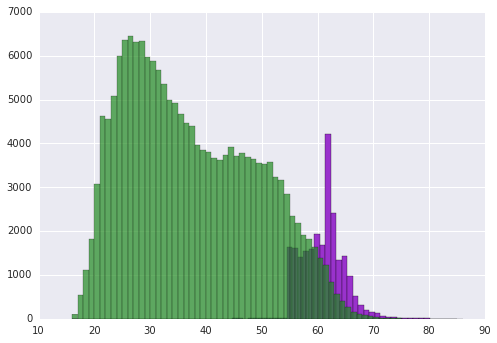

In [467]:
empl[empl['retired']==1].Age_years.hist(bins=70,range=[16,85],color='darkorchid')
empl[empl['retired']==0].Age_years.hist(bins=70,range=[16,86],color='forestgreen',alpha=0.7)

In [468]:
sum(empl.retired==1)

23466

In [471]:
pd.crosstab(empl.retired,empl.sep_status)

sep_status,0,1,2
retired,,,
0,69805,71766,33562
1,1,18289,5176


In [473]:
empl[(empl.sep_status==0) & (empl.retired==1)]['KEY']

104741    185980322857378
Name: KEY, dtype: object

In [476]:
print empltbl[empltbl.KEY=='185980322857378'][date_columns]
empltbl[empltbl.KEY=='185980322857378'].Age_years

      TERMINATION_DT    HIRE_DT SERVICE_DT LAST_HIRE_DT  BIRTHDATE
15796     2015-01-01 1982-05-24 1986-05-26   2014-10-13 1958-06-26


15796    56.518614
Name: Age_years, dtype: float64

In [484]:
empltbl[empltbl.KEY=='185980322857378'][['ACTRES1','ACTRES2','ACTRES3','ACTRES4','ACTRES5','ACTRES6','ACTRES7','ACTRES9','ACTRES10']].values

array([['TRANSFER W/O JOB NUMBER CHANGE;RETIREE',
        'INVOL SEVERANCE AFTER 9/1/2005',
        'SALARY PLAN CHANGE;INCENTIVE;MERIT;TRANSFER W/O JOB NUMBER CHANGE',
        'TRANSFER W/O JOB NUMBER CHANGE;SP/DEP LOSES ELIGIBILITY;SALARY PLAN CHANGE;INCENTIVE;MERIT',
        'SP/DEP GAINS ELIGIBILITY;MISCELLANEOUS DATA CHANGE;INCENTIVE;MERIT;SALARY PLAN CHANGE',
        'MERIT', 'MERIT', 'SALARY PLAN CHANGE;SALARY PLAN CHANGE;MERIT',
        'MISCELLANEOUS DATA CHANGE;MERIT']], dtype=object)

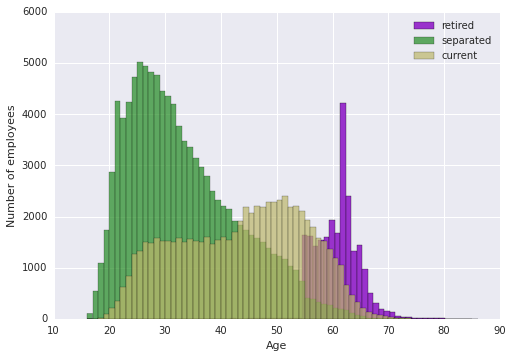

In [490]:
empl[empl['retired']==1].Age_years.hist(bins=70,range=[16,85],color='darkorchid',label='retired')
empl[(empl['retired']==0) & (empl.status==1)].Age_years.hist(bins=70,range=[16,86],color='forestgreen',alpha=0.7,label='separated')
empl[(empl['retired']==0) & (empl.status==0)].Age_years.hist(bins=70,range=[16,86],color='darkkhaki',alpha=0.7,label='current')
#empl[(empl['retired']==0) & (empl.status==1)].Age_years.hist(bins=70,range=[16,86],color='forestgreen',alpha=0.7)
plt.ylabel('Number of employees')
plt.xlabel('Age')
plt.legend()

In [492]:
sum(empl.SAL1== 0.0)

18118

In [493]:
len(empl)

198599

## April 27, 2015 
* need to categorize all data I can before loading into R

In [632]:
empltbl4=pd.read_csv('employee_dataframe4.tsv',sep='\t',index_col=0,dtype={'EMPL_CLASS':np.str,'EMPL_TYPE':np.str})
empltbl4.shape

(199419, 69)

In [633]:
sdf4 = summarize_dataframe2(empltbl4)

EXT_FUNC_ID_SFI object 0 	801
EMPL_CLASS object 0 	12
REH_CNT int64 0 	18
FLOR_SFI int64 0 	115
FULL_PART_TIME object 0 	4
ACTRES1 object 0 	25528
EEO1CODE object 0 	11
SHIFT object 0 	4
FUNCCNT1 int64 0 	4
LOC_STATE object 0 	52
INTERN object 0 	2
GRADE object 0 	164
TELE_MOS float64 0 	388
PERF1 float64 0 	78699
SUPVCNT1 int64 0 	12
ANNUAL_RT float64 0 	123705
LEGACY_DEPT_SFI object 0 	42660
CUR_LOC_MOS float64 0 	7883
Tenure_years float64 0 	15729
JOB_FAMILY object 0 	1456
ADDRCNT1 int64 0 	6
Age_years float64 0 	19297
COMPANY int64 0 	7
CUR_JOB_MOS float64 0 	6476
FUNC_CNT int64 0 	12070
SEX object 0 	2
FULLPART1 object 0 	2
ETHNIC_GROUP float64 0 	8
RELOCATE_ALL_SFI object 0 	2
LOCATION object 0 	13535
HUBIND object 0 	2
Tenure_months float64 0 	15729
STD_HOURS float64 0 	144
JOBCNT1 int64 0 	7
FLOORCNT1 int64 0 	6
MIN_RT_ANNUAL float64 0 	1441
PTFTCNT1 int64 0 	3
KEY int64 0 	199419
FLSA_STATUS object 0 	3
FTPTCNT1 int64 0 	3
CUR_GRADE_MOS float64 0 	4876
GRADECNT1 int64 0 	5
EFU

In [517]:
sdf4[sdf4.datatype=='object']

,Column,datatype,nmissing,arity,accepted values
0,EXT_FUNC_ID_SFI,object,0,801,None
1,EMPL_CLASS,object,0,12,"[1, 3, D, T, O, 4, P, X, F, 5, 2, G]"
4,FULL_PART_TIME,object,0,4,"[F, P, N, X]"
5,ACTRES1,object,0,25528,None
6,EEO1CODE,object,0,11,"[2, 5, 1, 3, 7, 4, N, 6, 8, L, 9]"
7,SHIFT,object,0,4,"[1, 3, N, 2]"
9,LOC_STATE,object,0,52,None
10,INTERN,object,0,2,"[N, Y]"
11,GRADE,object,0,164,None
16,LEGACY_DEPT_SFI,object,0,42660,None


In [634]:
# convert ethnic_group to int
empltbl4['ETHNIC_GROUP'] = empltbl4['ETHNIC_GROUP'].apply(lambda x: int(x))

In [ ]:
empltbl4.STATE.value_counts()[empltbl4.STATE.value_counts()<50]

In [560]:
empltbl4.LOC_STATE.value_counts()[empltbl4.LOC_STATE.value_counts()<50]

VT    48
DC    31
RI     1
dtype: int64

In [548]:
empltbl4[empltbl4.STATE=='HH'][['status','LOC_STATE','STATE','KEY']]#in [11,29]]

,status,LOC_STATE,STATE,KEY
51720,1,IL,HH,225588627730305


In [558]:
empltbl[empltbl.STATE=='BC'][['KEY','LOC_STATE','STATE','status','POSTAL_SFI','ADDRESS1','ADDRESS2','TERMINATION_DT','GRADE','LOCATION']]

,KEY,LOC_STATE,STATE,status,POSTAL_SFI,ADDRESS1,ADDRESS2,TERMINATION_DT,GRADE,LOCATION
14707,957051751649497,PA,BC,1,NaN,3566 W 11TH AVE,NaN,1991-07-19,MA3,13921
17950,979422324327483,NaN,BC,1,NaN,42810 OLD ORCHARD ROAD,NaN,1992-06-12,MA4,99912
99046,583651340372698,CO,BC,1,V3T 5V2,10899 W WHALLEY RING RD,UNIT 1401,2005-08-26,PA2,20165
154057,494181554063308,IL,BC,1,V6S 1H4,3842 21ST AVE WEST,NaN,2010-12-09,UNS,00523
157419,690435683210583,IL,BC,1,V7C 4L8,4120 AMUNDSEN PLACE,NaN,2003-08-29,RA3,00915


In [541]:
empltbl[empltbl.KEY=='811710100533306'].values
#empltbl[empltbl.KEY=='296979068916747'].values

array([['MERIT;MISCONDUCT', nan,
        'LOCATION/FLOOR CHANGE;MERIT;JOB RECLASSIFICATION',
        'REVIEW DATE CHANGE;MERIT;DIVORCE/LEGAL SEP/ANNULMENT;ADDRESS CHANGE;TRANSFER WITH PROMOTION;RATING SCALE CONVERSION',
        'COMPANY WIDE CONVERSION;REGIONAL CONVERSION;ADDRESS CHANGE;COST OF LIVING ADJUSTMENT;TRANSFER W/O JOB NUMBER CHANGE;MERIT',
        'COST OF LIVING ADJUSTMENT;TRANSFER W/O JOB NUMBER CHANGE;MERIT',
        'MERIT', 'EMPLOYEE NEW HIRE', nan, nan, 0.0, 3.0, 1.0, 1.0,
        '7-1-3 NANSHGON', 'SAN LIBE', 72459.81, 1348963200000000000L,
        42.74694210011157, Timestamp('1960-11-08 00:00:00'), 'L', nan, 'S',
        'S', 'S', 'S', 'S', nan, nan, nan, '001', 'A', 23.2580645,
        26.1935484, 26.1935484, 14.935483900000001, 14.935483900000001,
        69.19354840000001, 0, 4, 2, 4, 6.0, '9', '2', 0, 1, 1, 1, '1', 'S',
        4.0, 117.0, '00615', 0, 2, 2, 2, 883, 'Z', 1.0, 0, 0, 0, 0, 'N',
        'N', 'N', 'N', 'F', 0, 1, 1, 1, 117.0, '00614', 'RD2', 0, 2, 2,

In [543]:
empltbl[empltbl.KEY=='811710100533306'][['ADDRESS1','ADDRESS2','LOCATION','POSTAL_SFI']]

,ADDRESS1,ADDRESS2,LOCATION,POSTAL_SFI
162088,7-1-3 NANSHGON,SAN LIBE,00915,100045


In [635]:
empltbl4.SEX.value_counts()
empltbl4['COMP_FREQ_ANNUAL'] = 1
empltbl4.loc[empltbl4['COMP_FREQUENCY']=='H','COMP_FREQ_ANNUAL'] = 0
#empltbl4.drop('COMP_FREQUENCY',axis=1,inplace=True)

# now deal with male,female
empltbl4.replace({'SEX':{'M': 1,'F':0}},inplace=True)
empltbl4[['COMP_FREQ_ANNUAL','SEX','SHIFT']].head()

,COMP_FREQ_ANNUAL,SEX,SHIFT
0,1,1,1
1,0,0,1
2,1,0,1
3,1,0,1
4,1,1,1


In [636]:
empltbl4.COMP_FREQ_ANNUAL.value_counts()

1    187494
0     11925
dtype: int64

In [637]:
empltbl4.drop('COMP_FREQUENCY',axis=1,inplace=True)
empltbl4.drop('STATE',axis=1,inplace=True)
empltbl4.shape


(199419, 68)

In [638]:
# assign 1 to Y, 0 to N for the following columns
columns_to_fix_NY = ['INTERN','FULLPART1','RELOCATE_ALL_SFI','HUBIND','REMOTE','REMOTE_SUPV','SUPV_DIFF_LOC','PARTFULL1']
for acol in columns_to_fix_NY:
    empltbl4.replace({acol :{'Y':1,'N':0}},inplace=True) 

In [639]:
cols_to_cat = ['FLSA_STATUS','FULL_PART_TIME','SHIFT','EMPL_TYPE','COMPANY','ETHNIC_GROUP','EEO1CODE','EMPL_CLASS','JOB_FUNCTION']

In [575]:
sdf4.sort(['arity','datatype'],ascending =True)[sdf4.arity > 9]

,Column,datatype,nmissing,arity,accepted values
55,DIVISION_CODE_SFI,int64,0,10,"[1, 9, 0, 7, 2, 5, 3, 4, 6, -1]"
6,EEO1CODE,object,0,11,"[2, 5, 1, 3, 7, 4, N, 6, 8, L, 9]"
14,SUPVCNT1,int64,0,12,"[0, 3, 2, 1, 4, 5, 6, 8, 7, 9, 15, 10]"
1,EMPL_CLASS,object,0,12,"[1, 3, D, T, O, 4, P, X, F, 5, 2, G]"
2,REH_CNT,int64,0,18,"[0, 2, 1, 5, 4, 3, 13, 10, 6, 7, 8, 11, 12, 15..."
45,JOB_FUNCTION,object,0,19,"[PTB, PSA, XXX, NSA, PSC, PSB, PTD, MGT, PTA, ..."
9,LOC_STATE,object,0,52,None
56,RELO_STATE_CNT_SFI,int64,0,55,None
44,FTE,float64,0,82,None
3,FLOR_SFI,int64,0,115,None


In [577]:
## convert HIRE_DT to HIRE_YEAR
[c for c in empltbl4.columns if c.endswith('DT')]

['HIRE_DT']

In [640]:
empltbl4['hire_year'] = empltbl4['HIRE_DT'].apply(lambda x: int(x[:4]))

## define retirees

In [641]:
empltbl4['retired'] = empltbl4.ACTRES1.apply(lambda x: identify_retired(x))
sum(empltbl4.retired==1)

23466

In [642]:
# encode the VOLINVOL column as ['INVOLUNTARY':2,'VOLUNTARY':1,'NOT':0,'
empltbl4['sep_status'] = empltbl4['VOLINVOL'].replace({'NOT':0,'VOLUNTARY':1,'INVOLUNTARY':2,'OTHER':3,'UNKNOWN':3})
empltbl4.sep_status.value_counts()

1    90055
0    69806
2    38738
3      820
dtype: int64

In [643]:
empl = empltbl4.copy()

In [644]:
empl = empltbl4.copy()
empl.drop(['VOLINVOL','ACTRES1','HIRE_DT'],axis=1,inplace=True)
empl.head()

,EXT_FUNC_ID_SFI,EMPL_CLASS,REH_CNT,FLOR_SFI,FULL_PART_TIME,EEO1CODE,SHIFT,FUNCCNT1,LOC_STATE,INTERN,...,MERIT1,DEPTCNT1,FUNC_ID_SFI,EMPL_TYPE,CUR_FUNC_MOS,CUR_DEPT_MOS,COMP_FREQ_ANNUAL,hire_year,retired,sep_status
0,00315,1,0,999,F,2,1,0,AL,0,...,1036.470,0,00014,E,192.838710,27.677419,1,1967,1,2
1,00071,1,0,999,P,5,1,0,AZ,0,...,856.215,0,00933,H,6.709677,6.709677,0,2014,0,0
2,00541,1,0,999,F,5,1,0,OH,0,...,0.000,0,00029,E,0.000000,0.000000,1,1977,0,1
3,00816,1,0,999,F,5,1,0,FL,0,...,1619.640,0,00890,E,28.193548,28.193548,1,1975,1,2
4,00944,1,0,999,F,5,1,1,GA,0,...,4208.720,1,00941,E,10.967742,10.967742,1,2012,0,0


In [645]:
print "base_categories"
print "------------------------"
[(a,empl[a].value_counts().head(1)) for a in cols_to_cat]

base_categories
------------------------


[('FLSA_STATUS', N    142803
  dtype: int64), ('FULL_PART_TIME', F    171554
  dtype: int64), ('SHIFT', 1    160986
  dtype: int64), ('EMPL_TYPE', E    116476
  dtype: int64), ('COMPANY', 1    166214
  dtype: int64), ('ETHNIC_GROUP', 1    144921
  dtype: int64), ('EEO1CODE', 5    93585
  dtype: int64), ('EMPL_CLASS', 1    194163
  dtype: int64), ('JOB_FUNCTION', XXX    68899
  dtype: int64)]

In [646]:
def create_factorized_df(input_df,column_name):
    tmp_df = pd.get_dummies(input_df[column_name],prefix=column_name)
    # now drop the largest category
    lgst_category = input_df[column_name].value_counts().index[0]
    #print tmp_df.shape, tmp_df.columns
    #print lgst_category
    base_category = column_name+'_'+str(lgst_category)
    tmp_df.drop(base_category,axis=1,inplace=True)
    print tmp_df.shape, base_category
    return tmp_df,base_category
    

In [617]:
egrp, bc1 = create_factorized_df(empl,acol)

(199419, 7) ETHNIC_GROUP_1.0


In [618]:
sgrp, bc1 = create_factorized_dfrized_df(empl,'LOC_STATE')

(199419, 51) LOC_STATE_IL


In [647]:
# create a dummified dataframe.
base_category_list =[]
print empl.shape
for acol in cols_to_cat:
    print acol
    t_df,bc1 = create_factorized_df(empl,acol)
    # drop the original column
    empl.drop(acol,inplace=True,axis=1)
    # append the factorized categories
    empl = pd.concat([empl,t_df],axis=1)
    base_category_list.append(bc1)

print empl.shape,len(base_category_list)

(199419, 68)
FLSA_STATUS
(199419, 2) FLSA_STATUS_N
FULL_PART_TIME
(199419, 3) FULL_PART_TIME_F
SHIFT
(199419, 3) SHIFT_1
EMPL_TYPE
(199419, 4) EMPL_TYPE_E
COMPANY
(199419, 6) COMPANY_1
ETHNIC_GROUP
(199419, 7) ETHNIC_GROUP_1
EEO1CODE
(199419, 10) EEO1CODE_5
EMPL_CLASS
(199419, 11) EMPL_CLASS_1
JOB_FUNCTION
(199419, 18) JOB_FUNCTION_XXX
(199419, 123) 9


In [648]:
more_cols_to_cat = ['LOC_STATE','GRADE','EXT_FUNC_ID_SFI','JOB_FAMILY']

In [649]:
## remove sep_status == 3
empl=empl[empl.sep_status<3].copy()
empl.shape

(198599, 123)

In [650]:
for acol in more_cols_to_cat[:2]:
    print acol
    t_df,bc1 = create_factorized_df(empl,acol)
    # drop the original column
    empl.drop(acol,inplace=True,axis=1)
    # append the factorized categories
    empl = pd.concat([empl,t_df],axis=1)
    base_category_list.append(bc1)


LOC_STATE
(198599, 51) LOC_STATE_IL
GRADE
(198599, 163) GRADE_PA2


In [651]:
empl.shape

(198599, 335)

In [653]:
## save this to a file
empl.drop(more_cols_to_cat[2:],axis=1,inplace=True)
empl.drop('KEY',axis=1,inplace=True)
empl.to_csv('employee_dataframe5.tsv',sep='\t',index =False)

#### create integers for times; required for CoxPH in H2O.

In [759]:
empl[['Age','Tenure']] = empl[['Age_years','Tenure_years']].applymap(lambda x: int(round(x,0)))

In [760]:
empl[['Age','Age_years']].head()

,Age,Age_years
0,57,56.729433
1,21,21.322820
2,39,38.566158
3,63,62.963647
4,27,26.853392


In [762]:
empl.to_csv('employee_dataframe6.tsv',sep='\t',index =False)

In [774]:
sdfB = summarize_dataframe2(empl)

REH_CNT int64 0 	18
FLOR_SFI int64 0 	115
FUNCCNT1 int64 0 	4
INTERN int64 0 	2
TELE_MOS float64 0 	388
PERF1 float64 0 	78699
SUPVCNT1 int64 0 	12
ANNUAL_RT float64 0 	123538
CUR_LOC_MOS float64 0 	7883
Tenure_years float64 0 	15728
ADDRCNT1 int64 0 	6
Age_years float64 0 	19294
CUR_JOB_MOS float64 0 	6476
FUNC_CNT int64 0 	12063
SEX int64 0 	2
FULLPART1 int64 0 	2
RELOCATE_ALL_SFI int64 0 	2
HUBIND int64 0 	2
STD_HOURS float64 0 	144
JOBCNT1 int64 0 	7
FLOORCNT1 int64 0 	6
MIN_RT_ANNUAL float64 0 	1441
PTFTCNT1 int64 0 	3
FTPTCNT1 int64 0 	3
CUR_GRADE_MOS float64 0 	4876
GRADECNT1 int64 0 	5
EFUNCCNT1 int64 0 	6
CUR_EFUNC_MOS float64 0 	7917
FTE float64 0 	82
SAL1 float64 0 	123538
LOCSTCNT1 int64 0 	5
status int64 0 	2
REMOTE int64 0 	2
REMOTE_SUPV int64 0 	2
JOBCODE int64 0 	3791
SUPV_DIFF_LOC int64 0 	2
DIVISION_CODE_SFI int64 0 	10
RELO_STATE_CNT_SFI int64 0 	55
EXTFUNC_CNT int64 0 	10348
MAX_RT_ANNUAL float64 0 	1210
LOCCNT1 int64 0 	7
PARTFULL1 int64 0 	2
MERIT1 float64 0 	7827

In [775]:
sdfB.sort('arity')

,Column,datatype,nmissing,arity,accepted values
96,EMPL_CLASS_X,float64,0,1,[0.0]
3,INTERN,int64,0,2,"[0, 1]"
14,SEX,int64,0,2,"[1, 0]"
15,FULLPART1,int64,0,2,"[0, 1]"
16,RELOCATE_ALL_SFI,int64,0,2,"[0, 1]"
17,HUBIND,int64,0,2,"[0, 1]"
31,status,int64,0,2,"[1, 0]"
32,REMOTE,int64,0,2,"[0, 1]"
33,REMOTE_SUPV,int64,0,2,"[0, 1]"
35,SUPV_DIFF_LOC,int64,0,2,"[0, 1]"


In [776]:

#empl.FUNC_ID_SFI.value_counts()

14     91609
29     15287
9      12818
38      9254
39      8857
6       8805
20      5941
933     5501
16      5123
890     4122
41      3841
1       3837
23      3269
515     3074
730     2099
...
 30     23
 7      21
 508    21
-1      15
 31     15
 8      13
 28     12
 27     11
 36      9
 810     4
 518     2
 33      2
 40      2
 506     2
 11      1
Length: 64, dtype: int64

In [663]:
def convert_to_int(x):
    try:
        x=int(x)
    except:
        x=-1
    return x

empl.FUNC_ID_SFI = empl.FUNC_ID_SFI.apply(lambda x: convert_to_int(x))
len(empl.FUNC_ID_SFI.unique())

64

In [665]:
len(empl)

198599

In [673]:
empl.drop(['LOCATION','LEGACY_DEPT_SFI','Tenure_months'],axis=1,inplace=True)

In [674]:
empl.to_csv('employee_dataframe5.tsv',sep='\t',ignore_index =True)

In [676]:
[c for c  in enumerate(list(empl.columns))]

[(0, 'REH_CNT'),
 (1, 'FLOR_SFI'),
 (2, 'FUNCCNT1'),
 (3, 'INTERN'),
 (4, 'TELE_MOS'),
 (5, 'PERF1'),
 (6, 'SUPVCNT1'),
 (7, 'ANNUAL_RT'),
 (8, 'CUR_LOC_MOS'),
 (9, 'Tenure_years'),
 (10, 'ADDRCNT1'),
 (11, 'Age_years'),
 (12, 'CUR_JOB_MOS'),
 (13, 'FUNC_CNT'),
 (14, 'SEX'),
 (15, 'FULLPART1'),
 (16, 'RELOCATE_ALL_SFI'),
 (17, 'HUBIND'),
 (18, 'STD_HOURS'),
 (19, 'JOBCNT1'),
 (20, 'FLOORCNT1'),
 (21, 'MIN_RT_ANNUAL'),
 (22, 'PTFTCNT1'),
 (23, 'FTPTCNT1'),
 (24, 'CUR_GRADE_MOS'),
 (25, 'GRADECNT1'),
 (26, 'EFUNCCNT1'),
 (27, 'CUR_EFUNC_MOS'),
 (28, 'FTE'),
 (29, 'SAL1'),
 (30, 'LOCSTCNT1'),
 (31, 'status'),
 (32, 'REMOTE'),
 (33, 'REMOTE_SUPV'),
 (34, 'JOBCODE'),
 (35, 'SUPV_DIFF_LOC'),
 (36, 'DIVISION_CODE_SFI'),
 (37, 'RELO_STATE_CNT_SFI'),
 (38, 'EXTFUNC_CNT'),
 (39, 'MAX_RT_ANNUAL'),
 (40, 'LOCCNT1'),
 (41, 'PARTFULL1'),
 (42, 'MERIT1'),
 (43, 'DEPTCNT1'),
 (44, 'FUNC_ID_SFI'),
 (45, 'CUR_FUNC_MOS'),
 (46, 'CUR_DEPT_MOS'),
 (47, 'COMP_FREQ_ANNUAL'),
 (48, 'hire_year'),
 (49, 'retire

In [672]:
empl.loc[:2000,'status'].value_counts()

1    1313
0     683
dtype: int64

In [677]:
empl.loc[:2000,'retired'].value_counts()

0    1737
1     259
dtype: int64

In [678]:
sum(empl.retired==1)

23466

In [679]:
empl.loc[:4000,'retired'].value_counts()


0    3504
1     488
dtype: int64

In [ ]:
#X = patsy.dmatrix('Age_years + COMPANY + INTERN + SEX',empltbl4, return_type='dataframe')
#X.columns
aaf = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
X['T'] = empltbl4['Tenure_years']
X['E'] = empltbl4['status']

In [ ]:
empl.Age_years

In [702]:
Xft = patsy.dmatrix( 'Age_years +ANNUAL_RT+PERF1+INTERN+SEX',empl,return_type='dataframe')
Xft.shape

(198599, 6)

In [703]:
Xft['T'] = empl.Tenure_years#empl.ix[:4010]['Tenure_years']
Xft['E']=empl.retired#empl.ix[:4010]['retired']

In [704]:
aaf_ret = AalenAdditiveFitter(penalizer=1.0, fit_intercept=True)
aaf_ret.fit(Xft,'T','E')

 [-----------------100%-----------------] 23466 of 23466 complete in 557.2 sec


<lifelines.AalenAdditiveFitter: fitted with 198599 observations, 175133 censored>

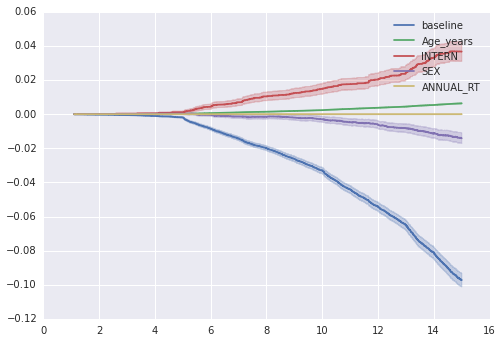

In [705]:
aaf_ret.plot(columns=['baseline','Age_years','INTERN','SEX','ANNUAL_RT'],ix=slice(1,15))

In [691]:
from lifelines import CoxPHFitter
cf = CoxPHFitter()

In [694]:
%%time 
cf.fit(Xft[Xft.columns[1:]],'T','E')

CPU times: user 1.57 s, sys: 3 ms, total: 1.57 s
Wall time: 1.57 s


<lifelines.CoxPHFitter: fitted with 4002 observations, 3514 censored>

In [696]:
cf.summary()

n=4002, number of events=488

                coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
Age_years  8.980e-01  2.455e+00 8.641e-02  1.039e+01 2.700e-25   7.286e-01   1.067e+00  ***
ANNUAL_RT -1.520e-01  8.590e-01 4.966e-02 -3.060e+00 2.212e-03  -2.493e-01  -5.462e-02   **
PERF1     -2.240e-01  7.993e-01 4.415e-02 -5.075e+00 3.885e-07  -3.106e-01  -1.375e-01  ***
INTERN    -2.822e-02  9.722e-01 1.069e-01 -2.639e-01 7.918e-01  -2.379e-01   1.814e-01     
SEX       -4.003e-02  9.608e-01 4.922e-02 -8.131e-01 4.161e-01  -1.365e-01   5.647e-02     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.790


In [697]:
few_columns1=['Age_years','ANNUAL_RT','PERF1','INTERN','SEX','Tenure_years','retired']
reduced1 = empl.loc[:,few_columns1].copy()
reduced1.shape

(198599, 7)

In [698]:
%%time 
cf.fit(reduced1,'Tenure_years','retired')

CPU times: user 45.3 s, sys: 99 ms, total: 45.4 s
Wall time: 45.4 s


<lifelines.CoxPHFitter: fitted with 198599 observations, 175133 censored>

In [699]:
cf.summary()

n=198599, number of events=23466

                coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
Age_years  9.393e-01  2.558e+00 1.368e-02  6.864e+01  0.000e+00   9.125e-01   9.661e-01  ***
ANNUAL_RT -1.770e-01  8.378e-01 6.234e-03 -2.840e+01 2.247e-177  -1.892e-01  -1.648e-01  ***
PERF1     -2.116e-01  8.093e-01 6.413e-03 -3.300e+01 8.059e-239  -2.242e-01  -1.990e-01  ***
INTERN    -4.951e-02  9.517e-01 1.426e-02 -3.472e+00  5.165e-04  -7.746e-02  -2.155e-02  ***
SEX        4.681e-02  1.048e+00 6.982e-03  6.704e+00  2.021e-11   3.312e-02   6.050e-02  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.788


In [700]:
cf.confidence_intervals_.head()

,Age_years,ANNUAL_RT,PERF1,INTERN,SEX
lower-bound,0.912474,-0.189231,-0.224192,-0.077459,0.033123
upper-bound,0.966129,-0.164790,-0.199049,-0.021554,0.060498


In [701]:
cf.hazards_.head()

,Age_years,ANNUAL_RT,PERF1,INTERN,SEX
coef,0.939301,-0.17701,-0.21162,-0.049507,0.04681


In [708]:
sum(aaf_ret.event_observed)

23466

In [709]:
from lifelines.utils import k_fold_cross_validation
xv_cf = CoxPHFitter()
cf_scores = k_fold_cross_validation(xv_cf, reduced1,duration_col='Tenure_years',event_col='retired',k=10)

In [712]:
cf_scores.mean(), cf_scores.std()

(0.47467166353332135, 0.0021963001536540439)

In [714]:
xv_cf.hazards_

,Age_years,ANNUAL_RT,PERF1,INTERN,SEX
coef,0.941564,-0.176551,-0.212476,-0.050769,0.044203


In [740]:
reduced1.ix[44]

Age_years          63.513967
ANNUAL_RT       73920.000000
PERF1               0.000000
INTERN              0.000000
SEX                 1.000000
Tenure_years       45.252127
retired             1.000000
Name: 44, dtype: float64

In [746]:
np.shape(reduced1.iloc[4:5,:-2].values)
retired_sf_avg = xv_cf.predict_survival_function(reduced1[reduced1.retired==1][reduced1.columns[:-2]].values).mean(axis=1)#.plot()#.iloc[34:35,:-2].values).plot()

In [749]:
notretired_sf_avg = xv_cf.predict_survival_function(reduced1[reduced1.retired==0][reduced1.columns[:-2]].values).mean(axis=1)

In [752]:
xv_cf.predict_survival_function(re

event_at
0.000000    1
0.002738    1
0.005476    1
0.008214    1
0.010952    1
dtype: float64

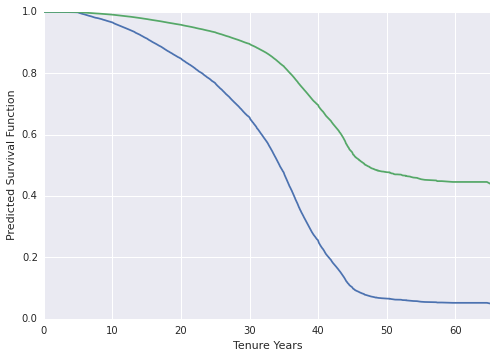

In [751]:
retired_sf_avg.plot(label='retired')
notretired_sf_avg.plot(label='not-retired')
plt.xlabel('Tenure Years')
plt.ylabel('Predicted Survival Function')

In [738]:
reduced1.iloc[24:25,:-2]

,Age_years,ANNUAL_RT,PERF1,INTERN,SEX
24,62.246316,41996.9,2346.65,0,0


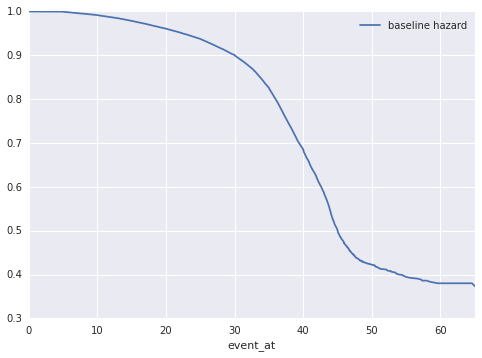

In [734]:
cf.baseline_survival_.plot()

## examining relationships (correlations) between columns

In [763]:
empl[['Tenure_years','hire_year']].corr()

,Tenure_years,hire_year
Tenure_years,1.00000,-0.74772
hire_year,-0.74772,1.00000


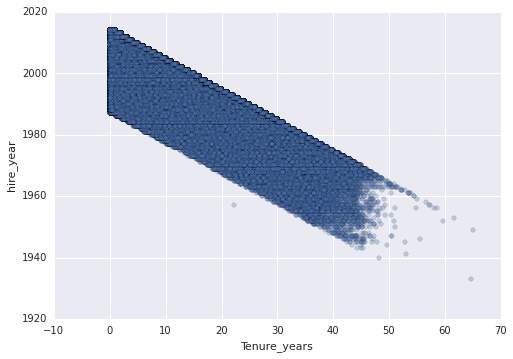

In [768]:
empl.plot(kind='scatter',x='Tenure_years',y='hire_year',
          alpha=0.3)

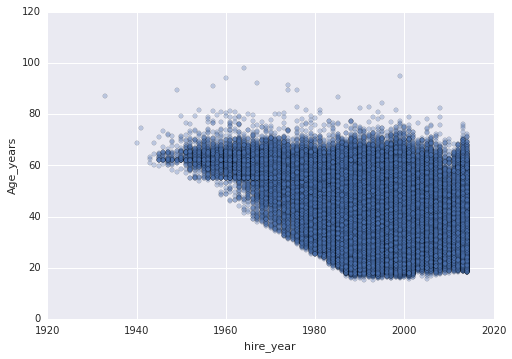

In [771]:
empl.plot(kind='scatter',x='hire_year',y='Age_years',
          alpha=0.3)

In [781]:
[x for x in empl.columns if x.endswith('MOS')]

['TELE_MOS',
 'CUR_LOC_MOS',
 'CUR_JOB_MOS',
 'CUR_GRADE_MOS',
 'CUR_EFUNC_MOS',
 'CUR_FUNC_MOS',
 'CUR_DEPT_MOS']

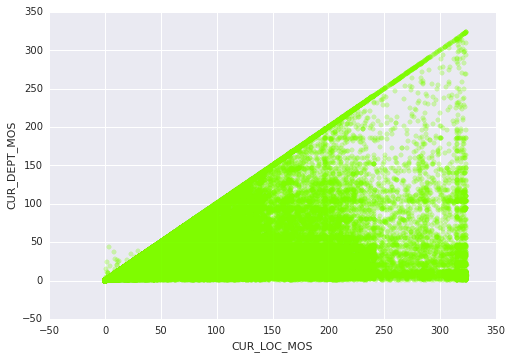

In [786]:
empl.plot(kind='scatter',x='CUR_LOC_MOS',y='CUR_DEPT_MOS',color='chartreuse',          alpha=0.3)

In [778]:
pd.crosstab(empl.CUR_DEPT_MOS,empl.CUR_FUNC_MOS)

CUR_FUNC_MOS,-0.0322581,0.0,0.03225806,0.06451613,0.09677419,0.12903226,0.16129032,0.19354839,0.22580645,0.25806452,...,323.580645,323.612903,323.645161,323.677419,323.709677,323.741935,323.806452,323.870968,323.935484,323.967742
CUR_DEPT_MOS,,,,,,,,,,,,,,,,,,,,,
-0.032258,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.000000,0,52757,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.032258,0,0,69,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.064516,0,0,0,66,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.096774,0,0,0,0,64,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.129032,0,0,0,0,0,54,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.161290,0,0,0,0,0,0,70,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.193548,0,0,0,0,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0
0.225806,0,0,0,0,0,0,0,0,29,0,...,0,0,0,0,0,0,0,0,0,0


In [788]:
empl.Tenure.describe()


count    198599.000000
mean         11.410727
std          11.615408
min           0.000000
25%           2.000000
50%           7.000000
75%          19.000000
max          65.000000
dtype: float64

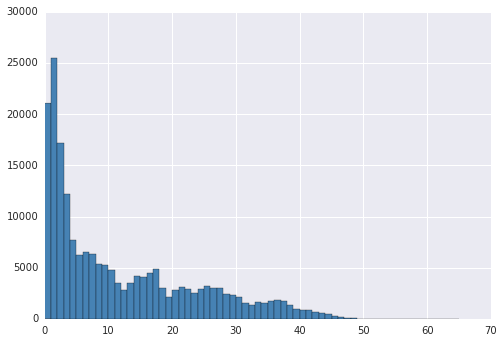

In [789]:
empl.Tenure.hist(bins=65,color='steelblue')

## EXPLORE more about some of these features.
* especially ones that may be missing or zeroed out
* SAL1, MIN_RT_ANNUAL

In [791]:
empl.MIN_RT_ANNUAL.describe()

count    198599.000000
mean      28525.694331
std       24164.554077
min           0.000000
25%           0.000000
50%       26708.320000
75%       44916.070000
max      203700.000000
dtype: float64

In [793]:
sum(empl.MIN_RT_ANNUAL==0.0), sum(empl.MAX_RT_ANNUAL==0.0)

(56488, 16158)

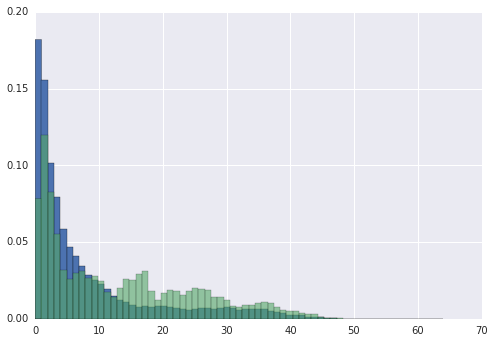

In [799]:
empl[empl.MIN_RT_ANNUAL==0.0]['Tenure'].hist(range=[0,64],normed=True,bins=65)
empl[empl.MIN_RT_ANNUAL!=0.0]['Tenure'].hist(range=[0,64],normed=True,bins=65,alpha=0.6)

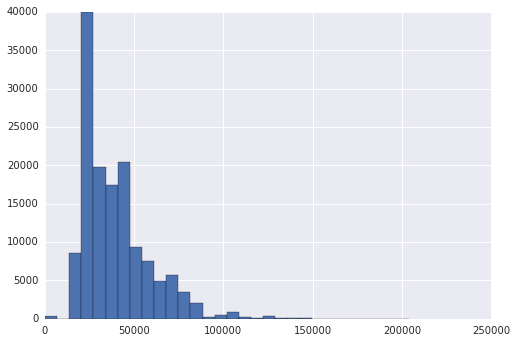

In [802]:
empl[empl.MIN_RT_ANNUAL>0].MIN_RT_ANNUAL.hist(bins=30)

In [804]:
empl[empl.MIN_RT_ANNUAL>1].MIN_RT_ANNUAL.describe()

count    141757.000000
mean      39963.980741
std       18998.641421
min       15537.600000
25%       26098.140000
50%       35299.900000
75%       47968.620000
max      203700.000000
dtype: float64

In [805]:
empl[empl.MAX_RT_ANNUAL>1].MAX_RT_ANNUAL.describe()

count     182441.000000
mean      303497.697493
std       655005.684383
min        20079.360000
25%        45682.560000
50%        78795.000000
75%       142238.630000
max      9999999.990000
dtype: float64

count    198599.000000
mean          0.310701
std           2.245677
min          -0.032258
25%           0.000000
50%           0.000000
75%           0.000000
max         180.645161
dtype: float64


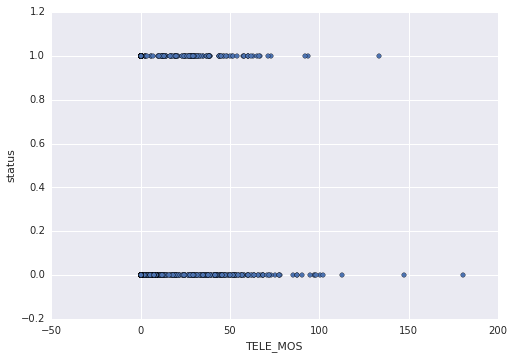

In [808]:
print empl.TELE_MOS.describe()
empl.plot(kind='scatter', x='TELE_MOS',y='status')

In [828]:
[c for c in empl.columns if c.startswith('JOB_FUNCTION')]
#pd.crosstab(empl.GRADE_MA1,empl.JOB_FUNCTION_OTH)

['JOB_FUNCTION_MGT',
 'JOB_FUNCTION_NSA',
 'JOB_FUNCTION_PSA',
 'JOB_FUNCTION_PSB',
 'JOB_FUNCTION_PSC',
 'JOB_FUNCTION_PTA',
 'JOB_FUNCTION_PTB',
 'JOB_FUNCTION_PTC',
 'JOB_FUNCTION_PTD',
 'JOB_FUNCTION_PTE',
 'JOB_FUNCTION_PTF',
 'JOB_FUNCTION_PTG',
 'JOB_FUNCTION_PTH',
 'JOB_FUNCTION_PTI',
 'JOB_FUNCTION_PTJ',
 'JOB_FUNCTION_PTK',
 'JOB_FUNCTION_PTL',
 'JOB_FUNCTION_PTM']

In [832]:
pd.crosstab(empltbl4.GRADE,empltbl4.JOB_FUNCTION)

JOB_FUNCTION,MGT,NSA,PSA,PSB,PSC,PTA,PTB,PTC,PTD,PTE,PTF,PTG,PTH,PTI,PTJ,PTK,PTL,PTM,XXX
GRADE,,,,,,,,,,,,,,,,,,,
22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,57
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23
24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13
25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12
26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14
27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20
28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21
29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10
AG3,0,224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
